# Integrating a Keras model into a Nengo network

Often we may want to define one part of our model in Nengo, and another part in
TensorFlow.  For example, suppose we are building a biological reinforcement learning
model, but we'd like the inputs to our model to be natural images rather than artificial
vectors.  We could load a vision network from TensorFlow, insert it into our model using
NengoDL, and then build the rest of our model using normal Nengo syntax.

NengoDL supports this through the
[TensorNode](https://www.nengo.ai/nengo-dl/tensor_node.html) class.  This allows us to
write code directly in TensorFlow, and then insert it easily into Nengo.  In this
example we will demonstrate how to integrate a Keras network into a Nengo model in a
series of stages. First, inserting an entire Keras model, second, inserting individual
Keras layers, and third, using native Nengo objects.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import nengo
import nengo_dl

# keras uses the global random seeds, so we set those here to
# ensure the example is reproducible
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

**Introduction to TensorNodes**

`nengo_dl.TensorNode` works very similarly to `nengo.Node`, except instead of using the
node to insert Python code into our model we will use it to insert TensorFlow code.

The first thing we need to do is define our TensorNode output.  This is a function that
accepts the current simulation time (and, optionally, a batch of vectors) as input, and
produces a batch of vectors as output.  All of these variables will be represented as
`tf.Tensor` objects, and the internal operations of the TensorNode will be implemented
with TensorFlow operations. For example, we could use a TensorNode to output a `sin`
function:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

| #                           Simulating                              | 0:00:00

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

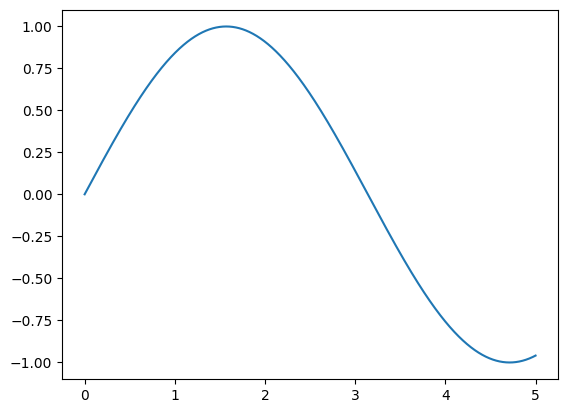

In [2]:
with nengo.Network() as net:

    def sin_func(t):
        # compute sin wave (based on simulation time)
        output = tf.sin(t)

        # convert output to the expected batched vector shape
        # (with batch size of 1 and vector dimensionality 1)
        output = tf.reshape(output, (1, 1))

        return output

    node = nengo_dl.TensorNode(sin_func)
    p = nengo.Probe(node)

with nengo_dl.Simulator(net) as sim:
    sim.run(5.0)

plt.figure()
plt.plot(sim.trange(), sim.data[p])
plt.show()

However, outputting a `sin` function is something we could do more easily with a regular
`nengo.Node`.  The main use case for `nengo_dl.TensorNode` is to allow us to write more
complex TensorFlow code and insert it into a NengoDL model. For example, one thing we
often want to do is take a deep network written in TensorFlow/Keras, and add it into a
Nengo model, which is what we will focus on in this notebook.

## Inserting a whole Keras model

[Keras](https://www.tensorflow.org/guide/keras/train_and_evaluate) is a popular software
package for building and training deep learning style networks.  It is a higher-level
API within TensorFlow to make it easier to construct and train deep networks.  And
because it is all implemented as a TensorFlow network under the hood, we can define a
network using Keras and then insert it into NengoDL using a TensorNode.

This example assumes familiarity with the Keras API. Specifically it is based on the
[introduction in the Tensorflow
documentation](https://www.tensorflow.org/tutorials/keras/classification), so if you are
not yet familiar with Keras, you may find it helpful to read those tutorials first.

In this example we'll train a neural network to classify the fashion MNIST dataset.
This dataset contains images of clothing, and the goal of the network is to identify
what type of clothing it is (e.g. t-shirt, trouser, coat, etc.).

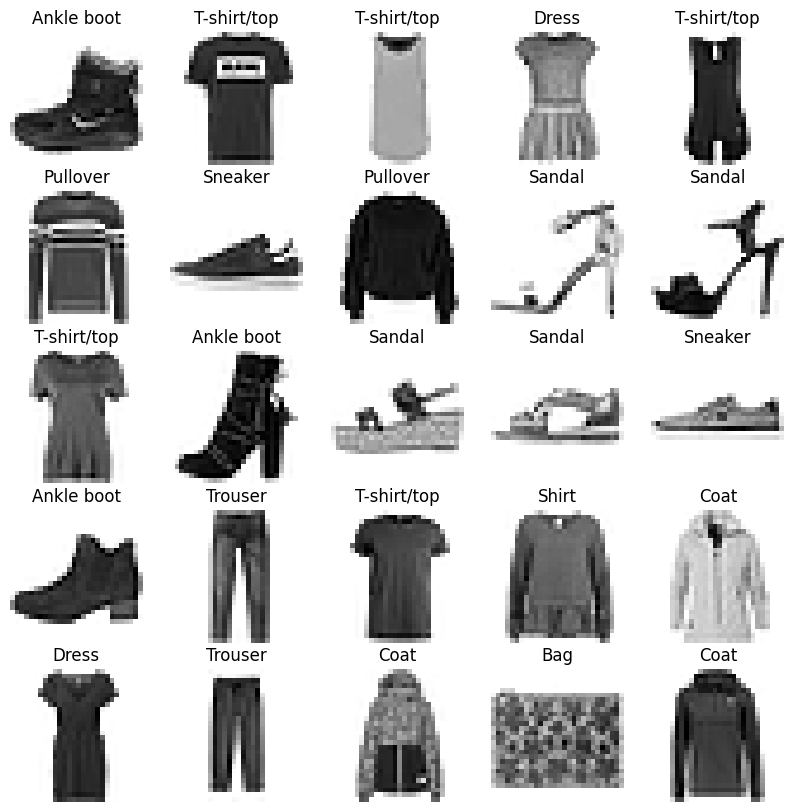

In [3]:
(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.fashion_mnist.load_data()

# normalize images so values are between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# flatten images
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
num_classes = len(class_names)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.axis("off")
    plt.title(class_names[train_labels[i]])

Next we build and train a simple neural network, using Keras.  In this case we're
building a simple two layer, densely connected network.

Note that alternatively we could define the network in Keras and then train it in
NengoDL (using the `Simulator.fit` function).  But for now we'll show how to do
everything in Keras.

In [4]:
inp = tf.keras.Input(train_images.shape[1:])
hidden = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(inp)
out = tf.keras.layers.Dense(units=num_classes)(hidden)

model = tf.keras.Model(inputs=inp, outputs=out)

model.compile(
    optimizer=tf.optimizers.Adam(),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.fit(train_images, train_labels, epochs=5)

print("Test accuracy:", model.evaluate(test_images, test_labels, verbose=0)[1])

Epoch 1/5


   1/1875 [..............................] - ETA: 17:12 - loss: 2.4725 - accuracy: 0.0625

  31/1875 [..............................] - ETA: 3s - loss: 1.3388 - accuracy: 0.5433   

  63/1875 [>.............................] - ETA: 2s - loss: 1.0912 - accuracy: 0.6190

  94/1875 [>.............................] - ETA: 2s - loss: 0.9585 - accuracy: 0.6632

 125/1875 [=>............................] - ETA: 2s - loss: 0.8848 - accuracy: 0.6913

 152/1875 [=>............................] - ETA: 2s - loss: 0.8380 - accuracy: 0.7079

 184/1875 [=>............................] - ETA: 2s - loss: 0.7993 - accuracy: 0.7215

 215/1875 [==>...........................] - ETA: 2s - loss: 0.7693 - accuracy: 0.7305

 245/1875 [==>...........................] - ETA: 2s - loss: 0.7437 - accuracy: 0.7408

 275/1875 [===>..........................] - ETA: 2s - loss: 0.7201 - accuracy: 0.7492

 304/1875 [===>..........................] - ETA: 2s - loss: 0.7040 - accuracy: 0.7539

 331/1875 [====>.........................] - ETA: 2s - loss: 0.6924 - accuracy: 0.7572

 363/1875 [====>.........................] - ETA: 2s - loss: 0.6783 - accuracy: 0.7624

 393/1875 [=====>........................] - ETA: 2s - loss: 0.6708 - accuracy: 0.7648

 425/1875 [=====>........................] - ETA: 2s - loss: 0.6593 - accuracy: 0.7699

 456/1875 [======>.......................] - ETA: 2s - loss: 0.6482 - accuracy: 0.7748

 487/1875 [======>.......................] - ETA: 2s - loss: 0.6411 - accuracy: 0.7775

 517/1875 [=======>......................] - ETA: 2s - loss: 0.6348 - accuracy: 0.7799

 549/1875 [=======>......................] - ETA: 2s - loss: 0.6262 - accuracy: 0.7825

 580/1875 [========>.....................] - ETA: 2s - loss: 0.6216 - accuracy: 0.7839

 612/1875 [========>.....................] - ETA: 2s - loss: 0.6136 - accuracy: 0.7865

 644/1875 [=========>....................] - ETA: 2s - loss: 0.6087 - accuracy: 0.7891

 676/1875 [=========>....................] - ETA: 2s - loss: 0.6013 - accuracy: 0.7918

 708/1875 [==========>...................] - ETA: 1s - loss: 0.5960 - accuracy: 0.7936

 739/1875 [==========>...................] - ETA: 1s - loss: 0.5912 - accuracy: 0.7950

 771/1875 [===========>..................] - ETA: 1s - loss: 0.5867 - accuracy: 0.7960

 803/1875 [===========>..................] - ETA: 1s - loss: 0.5817 - accuracy: 0.7972

 834/1875 [============>.................] - ETA: 1s - loss: 0.5794 - accuracy: 0.7977

 866/1875 [============>.................] - ETA: 1s - loss: 0.5760 - accuracy: 0.7992

 898/1875 [=============>................] - ETA: 1s - loss: 0.5723 - accuracy: 0.8005

 928/1875 [=============>................] - ETA: 1s - loss: 0.5668 - accuracy: 0.8027

 958/1875 [==============>...............] - ETA: 1s - loss: 0.5641 - accuracy: 0.8040

 989/1875 [==============>...............] - ETA: 1s - loss: 0.5598 - accuracy: 0.8049

1021/1875 [===============>..............] - ETA: 1s - loss: 0.5556 - accuracy: 0.8064

1050/1875 [===============>..............] - ETA: 1s - loss: 0.5528 - accuracy: 0.8074

1081/1875 [================>.............] - ETA: 1s - loss: 0.5493 - accuracy: 0.8089

1113/1875 [================>.............] - ETA: 1s - loss: 0.5471 - accuracy: 0.8096

1145/1875 [=================>............] - ETA: 1s - loss: 0.5439 - accuracy: 0.8111

1176/1875 [=================>............] - ETA: 1s - loss: 0.5412 - accuracy: 0.8116

1207/1875 [==================>...........] - ETA: 1s - loss: 0.5377 - accuracy: 0.8127

1239/1875 [==================>...........] - ETA: 1s - loss: 0.5354 - accuracy: 0.8133

1271/1875 [===================>..........] - ETA: 0s - loss: 0.5337 - accuracy: 0.8140

1302/1875 [===================>..........] - ETA: 0s - loss: 0.5319 - accuracy: 0.8145

1333/1875 [====================>.........] - ETA: 0s - loss: 0.5295 - accuracy: 0.8155

1364/1875 [====================>.........] - ETA: 0s - loss: 0.5275 - accuracy: 0.8161

1395/1875 [=====================>........] - ETA: 0s - loss: 0.5253 - accuracy: 0.8169

1425/1875 [=====================>........] - ETA: 0s - loss: 0.5224 - accuracy: 0.8179

1456/1875 [======================>.......] - ETA: 0s - loss: 0.5204 - accuracy: 0.8187

1488/1875 [======================>.......] - ETA: 0s - loss: 0.5176 - accuracy: 0.8197

1521/1875 [=======================>......] - ETA: 0s - loss: 0.5160 - accuracy: 0.8203

1552/1875 [=======================>......] - ETA: 0s - loss: 0.5149 - accuracy: 0.8204

1584/1875 [========================>.....] - ETA: 0s - loss: 0.5141 - accuracy: 0.8208

1616/1875 [========================>.....] - ETA: 0s - loss: 0.5124 - accuracy: 0.8213

1648/1875 [=========================>....] - ETA: 0s - loss: 0.5105 - accuracy: 0.8220

1680/1875 [=========================>....] - ETA: 0s - loss: 0.5086 - accuracy: 0.8227

1712/1875 [==========================>...] - ETA: 0s - loss: 0.5077 - accuracy: 0.8230

1743/1875 [==========================>...] - ETA: 0s - loss: 0.5058 - accuracy: 0.8237

1774/1875 [===========================>..] - ETA: 0s - loss: 0.5036 - accuracy: 0.8246

1806/1875 [===========================>..] - ETA: 0s - loss: 0.5026 - accuracy: 0.8248

1837/1875 [============================>.] - ETA: 0s - loss: 0.5014 - accuracy: 0.8253

1868/1875 [============================>.] - ETA: 0s - loss: 0.5009 - accuracy: 0.8254

1875/1875 [==============================] - 4s 2ms/step - loss: 0.5004 - accuracy: 0.8255


Epoch 2/5


   1/1875 [..............................] - ETA: 4s - loss: 0.1934 - accuracy: 0.9375

  33/1875 [..............................] - ETA: 2s - loss: 0.3803 - accuracy: 0.8722

  65/1875 [>.............................] - ETA: 2s - loss: 0.3815 - accuracy: 0.8721

  97/1875 [>.............................] - ETA: 2s - loss: 0.3926 - accuracy: 0.8640

 128/1875 [=>............................] - ETA: 2s - loss: 0.3995 - accuracy: 0.8623

 160/1875 [=>............................] - ETA: 2s - loss: 0.4037 - accuracy: 0.8582

 192/1875 [==>...........................] - ETA: 2s - loss: 0.4014 - accuracy: 0.8573

 224/1875 [==>...........................] - ETA: 2s - loss: 0.3961 - accuracy: 0.8590

 256/1875 [===>..........................] - ETA: 2s - loss: 0.3943 - accuracy: 0.8594

 287/1875 [===>..........................] - ETA: 2s - loss: 0.4015 - accuracy: 0.8562

 316/1875 [====>.........................] - ETA: 2s - loss: 0.4041 - accuracy: 0.8546

 348/1875 [====>.........................] - ETA: 2s - loss: 0.3995 - accuracy: 0.8569

 380/1875 [=====>........................] - ETA: 2s - loss: 0.3965 - accuracy: 0.8573

 412/1875 [=====>........................] - ETA: 2s - loss: 0.3933 - accuracy: 0.8578

 443/1875 [======>.......................] - ETA: 2s - loss: 0.3926 - accuracy: 0.8587

 474/1875 [======>.......................] - ETA: 2s - loss: 0.3928 - accuracy: 0.8577

 506/1875 [=======>......................] - ETA: 2s - loss: 0.3925 - accuracy: 0.8576

 537/1875 [=======>......................] - ETA: 2s - loss: 0.3908 - accuracy: 0.8593

 568/1875 [========>.....................] - ETA: 2s - loss: 0.3920 - accuracy: 0.8581

 598/1875 [========>.....................] - ETA: 2s - loss: 0.3915 - accuracy: 0.8578

 629/1875 [=========>....................] - ETA: 2s - loss: 0.3907 - accuracy: 0.8587

 661/1875 [=========>....................] - ETA: 1s - loss: 0.3920 - accuracy: 0.8575

 692/1875 [==========>...................] - ETA: 1s - loss: 0.3896 - accuracy: 0.8582

 724/1875 [==========>...................] - ETA: 1s - loss: 0.3910 - accuracy: 0.8579

 756/1875 [===========>..................] - ETA: 1s - loss: 0.3915 - accuracy: 0.8579

 788/1875 [===========>..................] - ETA: 1s - loss: 0.3909 - accuracy: 0.8582

 819/1875 [============>.................] - ETA: 1s - loss: 0.3915 - accuracy: 0.8578

 851/1875 [============>.................] - ETA: 1s - loss: 0.3889 - accuracy: 0.8594

 882/1875 [=============>................] - ETA: 1s - loss: 0.3877 - accuracy: 0.8602

 913/1875 [=============>................] - ETA: 1s - loss: 0.3874 - accuracy: 0.8607

 945/1875 [==============>...............] - ETA: 1s - loss: 0.3862 - accuracy: 0.8610

 977/1875 [==============>...............] - ETA: 1s - loss: 0.3856 - accuracy: 0.8609

1009/1875 [===============>..............] - ETA: 1s - loss: 0.3856 - accuracy: 0.8607

1040/1875 [===============>..............] - ETA: 1s - loss: 0.3847 - accuracy: 0.8608

1072/1875 [================>.............] - ETA: 1s - loss: 0.3845 - accuracy: 0.8612

1104/1875 [================>.............] - ETA: 1s - loss: 0.3833 - accuracy: 0.8616

1136/1875 [=================>............] - ETA: 1s - loss: 0.3817 - accuracy: 0.8623

1168/1875 [=================>............] - ETA: 1s - loss: 0.3820 - accuracy: 0.8621

1199/1875 [==================>...........] - ETA: 1s - loss: 0.3821 - accuracy: 0.8624

1231/1875 [==================>...........] - ETA: 1s - loss: 0.3825 - accuracy: 0.8624

1263/1875 [===================>..........] - ETA: 0s - loss: 0.3825 - accuracy: 0.8622

1294/1875 [===================>..........] - ETA: 0s - loss: 0.3832 - accuracy: 0.8618

1326/1875 [====================>.........] - ETA: 0s - loss: 0.3836 - accuracy: 0.8617

1358/1875 [====================>.........] - ETA: 0s - loss: 0.3833 - accuracy: 0.8618

1390/1875 [=====================>........] - ETA: 0s - loss: 0.3830 - accuracy: 0.8619

1422/1875 [=====================>........] - ETA: 0s - loss: 0.3819 - accuracy: 0.8623

1454/1875 [======================>.......] - ETA: 0s - loss: 0.3826 - accuracy: 0.8621

1483/1875 [======================>.......] - ETA: 0s - loss: 0.3822 - accuracy: 0.8624

1513/1875 [=======================>......] - ETA: 0s - loss: 0.3824 - accuracy: 0.8623

1545/1875 [=======================>......] - ETA: 0s - loss: 0.3825 - accuracy: 0.8621

1573/1875 [========================>.....] - ETA: 0s - loss: 0.3830 - accuracy: 0.8621

1605/1875 [========================>.....] - ETA: 0s - loss: 0.3828 - accuracy: 0.8622

1637/1875 [=========================>....] - ETA: 0s - loss: 0.3817 - accuracy: 0.8627

1668/1875 [=========================>....] - ETA: 0s - loss: 0.3813 - accuracy: 0.8629

1700/1875 [==========================>...] - ETA: 0s - loss: 0.3816 - accuracy: 0.8627

1732/1875 [==========================>...] - ETA: 0s - loss: 0.3815 - accuracy: 0.8627

1763/1875 [===========================>..] - ETA: 0s - loss: 0.3809 - accuracy: 0.8629

1795/1875 [===========================>..] - ETA: 0s - loss: 0.3802 - accuracy: 0.8632

1823/1875 [============================>.] - ETA: 0s - loss: 0.3804 - accuracy: 0.8633

1850/1875 [============================>.] - ETA: 0s - loss: 0.3791 - accuracy: 0.8640

1875/1875 [==============================] - 3s 2ms/step - loss: 0.3788 - accuracy: 0.8640


Epoch 3/5


   1/1875 [..............................] - ETA: 4s - loss: 0.4982 - accuracy: 0.8750

  33/1875 [..............................] - ETA: 2s - loss: 0.3476 - accuracy: 0.8693

  65/1875 [>.............................] - ETA: 2s - loss: 0.3654 - accuracy: 0.8663

  97/1875 [>.............................] - ETA: 2s - loss: 0.3572 - accuracy: 0.8708

 129/1875 [=>............................] - ETA: 2s - loss: 0.3539 - accuracy: 0.8714

 161/1875 [=>............................] - ETA: 2s - loss: 0.3514 - accuracy: 0.8723

 193/1875 [==>...........................] - ETA: 2s - loss: 0.3476 - accuracy: 0.8742

 225/1875 [==>...........................] - ETA: 2s - loss: 0.3393 - accuracy: 0.8765

 257/1875 [===>..........................] - ETA: 2s - loss: 0.3400 - accuracy: 0.8743

 285/1875 [===>..........................] - ETA: 2s - loss: 0.3407 - accuracy: 0.8745

 312/1875 [===>..........................] - ETA: 2s - loss: 0.3413 - accuracy: 0.8741

 333/1875 [====>.........................] - ETA: 2s - loss: 0.3391 - accuracy: 0.8755

 365/1875 [====>.........................] - ETA: 2s - loss: 0.3388 - accuracy: 0.8766

 397/1875 [=====>........................] - ETA: 2s - loss: 0.3381 - accuracy: 0.8764

 429/1875 [=====>........................] - ETA: 2s - loss: 0.3383 - accuracy: 0.8759

 461/1875 [======>.......................] - ETA: 2s - loss: 0.3406 - accuracy: 0.8753

 493/1875 [======>.......................] - ETA: 2s - loss: 0.3411 - accuracy: 0.8751

 525/1875 [=======>......................] - ETA: 2s - loss: 0.3425 - accuracy: 0.8753

 556/1875 [=======>......................] - ETA: 2s - loss: 0.3436 - accuracy: 0.8754

 585/1875 [========>.....................] - ETA: 2s - loss: 0.3422 - accuracy: 0.8760

 616/1875 [========>.....................] - ETA: 2s - loss: 0.3425 - accuracy: 0.8756

 648/1875 [=========>....................] - ETA: 2s - loss: 0.3438 - accuracy: 0.8750

 680/1875 [=========>....................] - ETA: 1s - loss: 0.3436 - accuracy: 0.8750

 712/1875 [==========>...................] - ETA: 1s - loss: 0.3453 - accuracy: 0.8743

 744/1875 [==========>...................] - ETA: 1s - loss: 0.3446 - accuracy: 0.8742

 776/1875 [===========>..................] - ETA: 1s - loss: 0.3467 - accuracy: 0.8736

 806/1875 [===========>..................] - ETA: 1s - loss: 0.3464 - accuracy: 0.8735

 837/1875 [============>.................] - ETA: 1s - loss: 0.3460 - accuracy: 0.8734

 868/1875 [============>.................] - ETA: 1s - loss: 0.3454 - accuracy: 0.8736

 901/1875 [=============>................] - ETA: 1s - loss: 0.3442 - accuracy: 0.8743

 932/1875 [=============>................] - ETA: 1s - loss: 0.3429 - accuracy: 0.8749

 964/1875 [==============>...............] - ETA: 1s - loss: 0.3418 - accuracy: 0.8752

 996/1875 [==============>...............] - ETA: 1s - loss: 0.3425 - accuracy: 0.8750

1028/1875 [===============>..............] - ETA: 1s - loss: 0.3422 - accuracy: 0.8752

1060/1875 [===============>..............] - ETA: 1s - loss: 0.3413 - accuracy: 0.8754

1092/1875 [================>.............] - ETA: 1s - loss: 0.3422 - accuracy: 0.8750

1124/1875 [================>.............] - ETA: 1s - loss: 0.3417 - accuracy: 0.8753

1155/1875 [=================>............] - ETA: 1s - loss: 0.3415 - accuracy: 0.8752

1187/1875 [=================>............] - ETA: 1s - loss: 0.3415 - accuracy: 0.8751

1218/1875 [==================>...........] - ETA: 1s - loss: 0.3412 - accuracy: 0.8754

1250/1875 [===================>..........] - ETA: 1s - loss: 0.3400 - accuracy: 0.8759

1281/1875 [===================>..........] - ETA: 0s - loss: 0.3397 - accuracy: 0.8759

1313/1875 [====================>.........] - ETA: 0s - loss: 0.3385 - accuracy: 0.8761

1345/1875 [====================>.........] - ETA: 0s - loss: 0.3396 - accuracy: 0.8760

1377/1875 [=====================>........] - ETA: 0s - loss: 0.3404 - accuracy: 0.8755

1409/1875 [=====================>........] - ETA: 0s - loss: 0.3408 - accuracy: 0.8755

1438/1875 [======================>.......] - ETA: 0s - loss: 0.3409 - accuracy: 0.8755

1470/1875 [======================>.......] - ETA: 0s - loss: 0.3408 - accuracy: 0.8755

1501/1875 [=======================>......] - ETA: 0s - loss: 0.3408 - accuracy: 0.8758

1533/1875 [=======================>......] - ETA: 0s - loss: 0.3420 - accuracy: 0.8755

1565/1875 [========================>.....] - ETA: 0s - loss: 0.3422 - accuracy: 0.8754

1597/1875 [========================>.....] - ETA: 0s - loss: 0.3424 - accuracy: 0.8752

1629/1875 [=========================>....] - ETA: 0s - loss: 0.3421 - accuracy: 0.8751

1661/1875 [=========================>....] - ETA: 0s - loss: 0.3423 - accuracy: 0.8752

1689/1875 [==========================>...] - ETA: 0s - loss: 0.3421 - accuracy: 0.8751

1721/1875 [==========================>...] - ETA: 0s - loss: 0.3420 - accuracy: 0.8750

1752/1875 [===========================>..] - ETA: 0s - loss: 0.3421 - accuracy: 0.8749

1782/1875 [===========================>..] - ETA: 0s - loss: 0.3417 - accuracy: 0.8750

1813/1875 [============================>.] - ETA: 0s - loss: 0.3413 - accuracy: 0.8752

1842/1875 [============================>.] - ETA: 0s - loss: 0.3407 - accuracy: 0.8753

1873/1875 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8754

1875/1875 [==============================] - 3s 2ms/step - loss: 0.3410 - accuracy: 0.8753


Epoch 4/5


   1/1875 [..............................] - ETA: 4s - loss: 0.1898 - accuracy: 0.9375

  33/1875 [..............................] - ETA: 2s - loss: 0.3336 - accuracy: 0.8693

  65/1875 [>.............................] - ETA: 2s - loss: 0.3425 - accuracy: 0.8683

  97/1875 [>.............................] - ETA: 2s - loss: 0.3330 - accuracy: 0.8756

 128/1875 [=>............................] - ETA: 2s - loss: 0.3221 - accuracy: 0.8804

 160/1875 [=>............................] - ETA: 2s - loss: 0.3157 - accuracy: 0.8811

 192/1875 [==>...........................] - ETA: 2s - loss: 0.3199 - accuracy: 0.8797

 224/1875 [==>...........................] - ETA: 2s - loss: 0.3176 - accuracy: 0.8816

 256/1875 [===>..........................] - ETA: 2s - loss: 0.3167 - accuracy: 0.8826

 287/1875 [===>..........................] - ETA: 2s - loss: 0.3187 - accuracy: 0.8834

 319/1875 [====>.........................] - ETA: 2s - loss: 0.3176 - accuracy: 0.8834

 350/1875 [====>.........................] - ETA: 2s - loss: 0.3182 - accuracy: 0.8829

 382/1875 [=====>........................] - ETA: 2s - loss: 0.3182 - accuracy: 0.8830

 413/1875 [=====>........................] - ETA: 2s - loss: 0.3180 - accuracy: 0.8832

 445/1875 [======>.......................] - ETA: 2s - loss: 0.3156 - accuracy: 0.8850

 477/1875 [======>.......................] - ETA: 2s - loss: 0.3180 - accuracy: 0.8843

 509/1875 [=======>......................] - ETA: 2s - loss: 0.3159 - accuracy: 0.8846

 540/1875 [=======>......................] - ETA: 2s - loss: 0.3121 - accuracy: 0.8862

 569/1875 [========>.....................] - ETA: 2s - loss: 0.3133 - accuracy: 0.8865

 601/1875 [========>.....................] - ETA: 2s - loss: 0.3136 - accuracy: 0.8858

 633/1875 [=========>....................] - ETA: 1s - loss: 0.3145 - accuracy: 0.8854

 665/1875 [=========>....................] - ETA: 1s - loss: 0.3144 - accuracy: 0.8856

 697/1875 [==========>...................] - ETA: 1s - loss: 0.3152 - accuracy: 0.8849

 729/1875 [==========>...................] - ETA: 1s - loss: 0.3149 - accuracy: 0.8850

 760/1875 [===========>..................] - ETA: 1s - loss: 0.3141 - accuracy: 0.8853

 786/1875 [===========>..................] - ETA: 1s - loss: 0.3132 - accuracy: 0.8856

 818/1875 [============>.................] - ETA: 1s - loss: 0.3118 - accuracy: 0.8861

 850/1875 [============>.................] - ETA: 1s - loss: 0.3118 - accuracy: 0.8860

 881/1875 [=============>................] - ETA: 1s - loss: 0.3118 - accuracy: 0.8861

 909/1875 [=============>................] - ETA: 1s - loss: 0.3112 - accuracy: 0.8861

 941/1875 [==============>...............] - ETA: 1s - loss: 0.3119 - accuracy: 0.8852

 972/1875 [==============>...............] - ETA: 1s - loss: 0.3118 - accuracy: 0.8854

1004/1875 [===============>..............] - ETA: 1s - loss: 0.3122 - accuracy: 0.8855

1035/1875 [===============>..............] - ETA: 1s - loss: 0.3124 - accuracy: 0.8855

1067/1875 [================>.............] - ETA: 1s - loss: 0.3138 - accuracy: 0.8848

1099/1875 [================>.............] - ETA: 1s - loss: 0.3134 - accuracy: 0.8850

1130/1875 [=================>............] - ETA: 1s - loss: 0.3126 - accuracy: 0.8852

1162/1875 [=================>............] - ETA: 1s - loss: 0.3133 - accuracy: 0.8850

1194/1875 [==================>...........] - ETA: 1s - loss: 0.3135 - accuracy: 0.8848

1226/1875 [==================>...........] - ETA: 1s - loss: 0.3128 - accuracy: 0.8848

1258/1875 [===================>..........] - ETA: 0s - loss: 0.3129 - accuracy: 0.8848

1290/1875 [===================>..........] - ETA: 0s - loss: 0.3130 - accuracy: 0.8847

1322/1875 [====================>.........] - ETA: 0s - loss: 0.3125 - accuracy: 0.8849

1354/1875 [====================>.........] - ETA: 0s - loss: 0.3122 - accuracy: 0.8853

1386/1875 [=====================>........] - ETA: 0s - loss: 0.3127 - accuracy: 0.8854

1419/1875 [=====================>........] - ETA: 0s - loss: 0.3123 - accuracy: 0.8858

1451/1875 [======================>.......] - ETA: 0s - loss: 0.3128 - accuracy: 0.8854

1482/1875 [======================>.......] - ETA: 0s - loss: 0.3132 - accuracy: 0.8853

1513/1875 [=======================>......] - ETA: 0s - loss: 0.3134 - accuracy: 0.8852

1545/1875 [=======================>......] - ETA: 0s - loss: 0.3133 - accuracy: 0.8852

1577/1875 [========================>.....] - ETA: 0s - loss: 0.3132 - accuracy: 0.8851

1609/1875 [========================>.....] - ETA: 0s - loss: 0.3138 - accuracy: 0.8849

1640/1875 [=========================>....] - ETA: 0s - loss: 0.3138 - accuracy: 0.8850

1671/1875 [=========================>....] - ETA: 0s - loss: 0.3135 - accuracy: 0.8849

1702/1875 [==========================>...] - ETA: 0s - loss: 0.3131 - accuracy: 0.8851

1728/1875 [==========================>...] - ETA: 0s - loss: 0.3129 - accuracy: 0.8853

1758/1875 [===========================>..] - ETA: 0s - loss: 0.3129 - accuracy: 0.8854

1784/1875 [===========================>..] - ETA: 0s - loss: 0.3137 - accuracy: 0.8852

1809/1875 [===========================>..] - ETA: 0s - loss: 0.3149 - accuracy: 0.8848

1836/1875 [============================>.] - ETA: 0s - loss: 0.3155 - accuracy: 0.8848

1866/1875 [============================>.] - ETA: 0s - loss: 0.3153 - accuracy: 0.8848

1875/1875 [==============================] - 3s 2ms/step - loss: 0.3153 - accuracy: 0.8847


Epoch 5/5


   1/1875 [..............................] - ETA: 4s - loss: 0.2488 - accuracy: 0.9375

  33/1875 [..............................] - ETA: 2s - loss: 0.3206 - accuracy: 0.8722

  62/1875 [..............................] - ETA: 3s - loss: 0.2923 - accuracy: 0.8836

  94/1875 [>.............................] - ETA: 2s - loss: 0.2739 - accuracy: 0.8923

 126/1875 [=>............................] - ETA: 2s - loss: 0.2812 - accuracy: 0.8906

 157/1875 [=>............................] - ETA: 2s - loss: 0.2877 - accuracy: 0.8901

 190/1875 [==>...........................] - ETA: 2s - loss: 0.2883 - accuracy: 0.8921

 222/1875 [==>...........................] - ETA: 2s - loss: 0.2909 - accuracy: 0.8929

 252/1875 [===>..........................] - ETA: 2s - loss: 0.2909 - accuracy: 0.8930

 284/1875 [===>..........................] - ETA: 2s - loss: 0.2911 - accuracy: 0.8934

 316/1875 [====>.........................] - ETA: 2s - loss: 0.2929 - accuracy: 0.8923

 348/1875 [====>.........................] - ETA: 2s - loss: 0.2945 - accuracy: 0.8915

 379/1875 [=====>........................] - ETA: 2s - loss: 0.2934 - accuracy: 0.8922

 407/1875 [=====>........................] - ETA: 2s - loss: 0.2933 - accuracy: 0.8923

 438/1875 [======>.......................] - ETA: 2s - loss: 0.2912 - accuracy: 0.8923

 470/1875 [======>.......................] - ETA: 2s - loss: 0.2921 - accuracy: 0.8916

 502/1875 [=======>......................] - ETA: 2s - loss: 0.2906 - accuracy: 0.8924

 533/1875 [=======>......................] - ETA: 2s - loss: 0.2924 - accuracy: 0.8917

 565/1875 [========>.....................] - ETA: 2s - loss: 0.2950 - accuracy: 0.8911

 597/1875 [========>.....................] - ETA: 2s - loss: 0.2963 - accuracy: 0.8909

 629/1875 [=========>....................] - ETA: 2s - loss: 0.2981 - accuracy: 0.8906

 661/1875 [=========>....................] - ETA: 1s - loss: 0.2994 - accuracy: 0.8903

 692/1875 [==========>...................] - ETA: 1s - loss: 0.2981 - accuracy: 0.8912

 724/1875 [==========>...................] - ETA: 1s - loss: 0.2982 - accuracy: 0.8910

 756/1875 [===========>..................] - ETA: 1s - loss: 0.2981 - accuracy: 0.8909

 788/1875 [===========>..................] - ETA: 1s - loss: 0.2981 - accuracy: 0.8908

 820/1875 [============>.................] - ETA: 1s - loss: 0.2964 - accuracy: 0.8913

 852/1875 [============>.................] - ETA: 1s - loss: 0.2958 - accuracy: 0.8915

 883/1875 [=============>................] - ETA: 1s - loss: 0.2960 - accuracy: 0.8914

 915/1875 [=============>................] - ETA: 1s - loss: 0.2972 - accuracy: 0.8911

 947/1875 [==============>...............] - ETA: 1s - loss: 0.2981 - accuracy: 0.8906

 979/1875 [==============>...............] - ETA: 1s - loss: 0.2984 - accuracy: 0.8905

1011/1875 [===============>..............] - ETA: 1s - loss: 0.2981 - accuracy: 0.8903

1043/1875 [===============>..............] - ETA: 1s - loss: 0.2971 - accuracy: 0.8909

1075/1875 [================>.............] - ETA: 1s - loss: 0.2963 - accuracy: 0.8910

1106/1875 [================>.............] - ETA: 1s - loss: 0.2954 - accuracy: 0.8913

1138/1875 [=================>............] - ETA: 1s - loss: 0.2956 - accuracy: 0.8913

1170/1875 [=================>............] - ETA: 1s - loss: 0.2952 - accuracy: 0.8914

1202/1875 [==================>...........] - ETA: 1s - loss: 0.2943 - accuracy: 0.8917

1234/1875 [==================>...........] - ETA: 1s - loss: 0.2964 - accuracy: 0.8910

1266/1875 [===================>..........] - ETA: 0s - loss: 0.2964 - accuracy: 0.8909

1298/1875 [===================>..........] - ETA: 0s - loss: 0.2961 - accuracy: 0.8911

1328/1875 [====================>.........] - ETA: 0s - loss: 0.2958 - accuracy: 0.8912

1360/1875 [====================>.........] - ETA: 0s - loss: 0.2962 - accuracy: 0.8913

1392/1875 [=====================>........] - ETA: 0s - loss: 0.2962 - accuracy: 0.8912

1424/1875 [=====================>........] - ETA: 0s - loss: 0.2973 - accuracy: 0.8906

1456/1875 [======================>.......] - ETA: 0s - loss: 0.2983 - accuracy: 0.8902

1488/1875 [======================>.......] - ETA: 0s - loss: 0.2985 - accuracy: 0.8903

1520/1875 [=======================>......] - ETA: 0s - loss: 0.2990 - accuracy: 0.8900

1552/1875 [=======================>......] - ETA: 0s - loss: 0.2984 - accuracy: 0.8902

1583/1875 [========================>.....] - ETA: 0s - loss: 0.2980 - accuracy: 0.8904

1615/1875 [========================>.....] - ETA: 0s - loss: 0.2978 - accuracy: 0.8904

1647/1875 [=========================>....] - ETA: 0s - loss: 0.2979 - accuracy: 0.8904

1679/1875 [=========================>....] - ETA: 0s - loss: 0.2975 - accuracy: 0.8905

1710/1875 [==========================>...] - ETA: 0s - loss: 0.2980 - accuracy: 0.8905

1742/1875 [==========================>...] - ETA: 0s - loss: 0.2984 - accuracy: 0.8903

1774/1875 [===========================>..] - ETA: 0s - loss: 0.2980 - accuracy: 0.8904

1806/1875 [===========================>..] - ETA: 0s - loss: 0.2980 - accuracy: 0.8905

1838/1875 [============================>.] - ETA: 0s - loss: 0.2977 - accuracy: 0.8907

1870/1875 [============================>.] - ETA: 0s - loss: 0.2980 - accuracy: 0.8905

1875/1875 [==============================] - 3s 2ms/step - loss: 0.2982 - accuracy: 0.8904


Test accuracy: 0.864799976348877


We'll save the trained weights, so that we can load them later within our TensorNode.

In [5]:
model_weights = "keras_weights"
model.save_weights(model_weights)

Now we're ready to create our TensorNode.  Our TensorNode needs to be a bit more
complicated in this case, since we need to load in the model from above and the
pretrained weights.  We can accomplish this by creating a custom Keras Layer, which
allows us to define `build` and `call` methods.

We'll use the `build` function to call the Keras `clone_model` function.  This
effectively reruns the Keras model definition from above, but because we're calling it
within the `build` stage it will be naturally integrated into the NengoDL model that is
being built.

The `call` function is where we do the main job of constructing the TensorFlow elements
that will implement our node.  It will take TensorFlow Tensors as input and produce a
`tf.Tensor` as output, as with the `tf.sin` example above.  In this case we apply the
Keras model to the TensorNode inputs.  This adds the TensorFlow elements that implement
that Keras model into the simulation graph.

In [6]:
class KerasWrapper(tf.keras.layers.Layer):
    def __init__(self, keras_model):
        super().__init__()

        self.model = keras_model

    def build(self, input_shape):
        super().build(input_shape)

        # we use clone_model to re-build the model
        # within the TensorNode context
        self.model = tf.keras.models.clone_model(self.model)

        # load the weights we saved above
        self.model.load_weights(model_weights)

    def call(self, inputs):
        # apply the model to the inputs
        return self.model(inputs)

Now that we have our `KerasWrapper` class, we can use it to insert our Keras model into
a Nengo network via a `TensorNode`. We simply instantiate a `KerasWrapper` (passing in
our Keras model from above), and then pass that Layer object to the `TensorNode`.

In [7]:
with nengo.Network() as net:
    # create a normal input node to feed in our test image.
    # the `np.ones` array is a placeholder, these
    # values will be replaced with the Fashion MNIST images
    # when we run the Simulator.
    input_node = nengo.Node(output=np.ones(28 * 28))

    # create an instance of the custom layer class we created,
    # passing it the Keras model
    layer = KerasWrapper(model)

    # create a TensorNode and pass it the new layer
    keras_node = nengo_dl.TensorNode(
        layer,
        shape_in=(28 * 28,),  # shape of input (the flattened images)
        shape_out=(num_classes,),  # shape of output (# of classes)
        pass_time=False,  # this node doesn't require time as input
    )

    # connect up our input to our keras node
    nengo.Connection(input_node, keras_node, synapse=None)

    # add a probe to collect output of keras node
    keras_p = nengo.Probe(keras_node)

At this point we could add any other Nengo components we like to the network, and
connect them up to the Keras node (for example, if we wanted to take the classified
image labels and use them as input to a spiking neural model).  But to keep things
simple, we'll stop here.

Now we can evaluate the performance of the Nengo network, to see if we have successfully
loaded the source Keras model.

In [8]:
# unlike in Keras, NengoDl simulations always run over time.
# so we need to add the time dimension to our data (even though
# in this case we'll just run for a single timestep).
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

test_images = test_images[:, None, :]
test_labels = test_labels[:, None, None]

In [9]:
with net:
    # we'll disable some features we don't need in this example, to improve
    # the training speed
    nengo_dl.configure_settings(stateful=False, use_loop=False)

minibatch_size = 20
with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    # call compile and evaluate, as we did with the Keras model
    sim.compile(
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    print(
        "Test accuracy:",
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"],
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Test accuracy: 0.864799976348877


We can see that we're getting the same performance in Nengo as we were in Keras,
indicating that we have successfully inserted the Keras model into Nengo.

## Inserting Keras layers

Rather than inserting an entire Keras model as a single block, we might want to
integrate a Keras model into Nengo by inserting the individual layers.  This requires
more manual translation work, but it makes it easier to make changes to the model later
on (for example, adding some spiking neuron layers).

We'll keep everything the same as above (same data, same network structure), but this
time we will recreate the Keras model one layer at a time.

As we saw above, we can wrap Keras Layers in a TensorNode by passing the layer object to
the TensorNode.  However, we can make this construction process even simpler by using
`nengo_dl.Layer`.  This is a different syntax for creating TensorNodes that mimics the
Keras functional layer API. Under the hood it's doing the same thing (creating
TensorNodes and Connections), but it allows us to define the model in a way that looks
very similar to the original Keras model definition.

In [10]:
with nengo.Network(seed=seed) as net:
    # input node, same as before
    inp = nengo.Node(output=np.ones(28 * 28))

    # add the Dense layers, as in the Keras model
    hidden = nengo_dl.Layer(tf.keras.layers.Dense(units=128, activation=tf.nn.relu))(
        inp
    )
    out = nengo_dl.Layer(tf.keras.layers.Dense(units=num_classes))(hidden)

    # add a probe to collect output
    out_p = nengo.Probe(out)

Since we're rebuilding the network within Nengo, we'll need to train it within NengoDL
this time. Fortunately, the API is essentially the same:

In [11]:
with net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    # call compile and fit with the same arguments as we used
    # in the original Keras model
    sim.compile(
        optimizer=tf.optimizers.Adam(),
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    sim.fit(train_images, train_labels, epochs=5)

    print(
        "Test accuracy:",
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"],
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Epoch 1/5


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

   1/3000 [..............................] - ETA: 17:34 - loss: 2.3860 - probe_loss: 2.3860 - probe_accuracy: 0.0500

  29/3000 [..............................] - ETA: 5s - loss: 1.4111 - probe_loss: 1.4111 - probe_accuracy: 0.5086   

  57/3000 [..............................] - ETA: 5s - loss: 1.1639 - probe_loss: 1.1639 - probe_accuracy: 0.5842

  84/3000 [..............................] - ETA: 5s - loss: 1.0600 - probe_loss: 1.0600 - probe_accuracy: 0.6321

 112/3000 [>.............................] - ETA: 5s - loss: 0.9762 - probe_loss: 0.9762 - probe_accuracy: 0.6643

 138/3000 [>.............................] - ETA: 5s - loss: 0.9129 - probe_loss: 0.9129 - probe_accuracy: 0.6830

 167/3000 [>.............................] - ETA: 5s - loss: 0.8756 - probe_loss: 0.8756 - probe_accuracy: 0.6973

 196/3000 [>.............................] - ETA: 5s - loss: 0.8508 - probe_loss: 0.8508 - probe_accuracy: 0.7059

 223/3000 [=>............................] - ETA: 5s - loss: 0.8328 - probe_loss: 0.8328 - probe_accuracy: 0.7103

 252/3000 [=>............................] - ETA: 5s - loss: 0.8092 - probe_loss: 0.8092 - probe_accuracy: 0.7188

 281/3000 [=>............................] - ETA: 4s - loss: 0.7924 - probe_loss: 0.7924 - probe_accuracy: 0.7267

 310/3000 [==>...........................] - ETA: 4s - loss: 0.7853 - probe_loss: 0.7853 - probe_accuracy: 0.7298

 339/3000 [==>...........................] - ETA: 4s - loss: 0.7594 - probe_loss: 0.7594 - probe_accuracy: 0.7397

 368/3000 [==>...........................] - ETA: 4s - loss: 0.7498 - probe_loss: 0.7498 - probe_accuracy: 0.7432

 396/3000 [==>...........................] - ETA: 4s - loss: 0.7351 - probe_loss: 0.7351 - probe_accuracy: 0.7477

 425/3000 [===>..........................] - ETA: 4s - loss: 0.7256 - probe_loss: 0.7256 - probe_accuracy: 0.7514

 453/3000 [===>..........................] - ETA: 4s - loss: 0.7146 - probe_loss: 0.7146 - probe_accuracy: 0.7552

 482/3000 [===>..........................] - ETA: 4s - loss: 0.6990 - probe_loss: 0.6990 - probe_accuracy: 0.7601

 511/3000 [====>.........................] - ETA: 4s - loss: 0.6905 - probe_loss: 0.6905 - probe_accuracy: 0.7628

 540/3000 [====>.........................] - ETA: 4s - loss: 0.6846 - probe_loss: 0.6846 - probe_accuracy: 0.7658

 569/3000 [====>.........................] - ETA: 4s - loss: 0.6763 - probe_loss: 0.6763 - probe_accuracy: 0.7680

 597/3000 [====>.........................] - ETA: 4s - loss: 0.6684 - probe_loss: 0.6684 - probe_accuracy: 0.7705

 626/3000 [=====>........................] - ETA: 4s - loss: 0.6651 - probe_loss: 0.6651 - probe_accuracy: 0.7720

 654/3000 [=====>........................] - ETA: 4s - loss: 0.6613 - probe_loss: 0.6613 - probe_accuracy: 0.7735

 683/3000 [=====>........................] - ETA: 4s - loss: 0.6562 - probe_loss: 0.6562 - probe_accuracy: 0.7750

 712/3000 [======>.......................] - ETA: 4s - loss: 0.6484 - probe_loss: 0.6484 - probe_accuracy: 0.7774

 741/3000 [======>.......................] - ETA: 4s - loss: 0.6424 - probe_loss: 0.6424 - probe_accuracy: 0.7798

 764/3000 [======>.......................] - ETA: 4s - loss: 0.6369 - probe_loss: 0.6369 - probe_accuracy: 0.7819

 793/3000 [======>.......................] - ETA: 3s - loss: 0.6322 - probe_loss: 0.6322 - probe_accuracy: 0.7840

 820/3000 [=======>......................] - ETA: 3s - loss: 0.6280 - probe_loss: 0.6280 - probe_accuracy: 0.7855

 849/3000 [=======>......................] - ETA: 3s - loss: 0.6240 - probe_loss: 0.6240 - probe_accuracy: 0.7872

 878/3000 [=======>......................] - ETA: 3s - loss: 0.6212 - probe_loss: 0.6212 - probe_accuracy: 0.7882

 907/3000 [========>.....................] - ETA: 3s - loss: 0.6180 - probe_loss: 0.6180 - probe_accuracy: 0.7889

 935/3000 [========>.....................] - ETA: 3s - loss: 0.6151 - probe_loss: 0.6151 - probe_accuracy: 0.7897

 963/3000 [========>.....................] - ETA: 3s - loss: 0.6135 - probe_loss: 0.6135 - probe_accuracy: 0.7903

 992/3000 [========>.....................] - ETA: 3s - loss: 0.6087 - probe_loss: 0.6087 - probe_accuracy: 0.7918

1021/3000 [=========>....................] - ETA: 3s - loss: 0.6035 - probe_loss: 0.6035 - probe_accuracy: 0.7930

1046/3000 [=========>....................] - ETA: 3s - loss: 0.6010 - probe_loss: 0.6010 - probe_accuracy: 0.7944

1074/3000 [=========>....................] - ETA: 3s - loss: 0.5968 - probe_loss: 0.5968 - probe_accuracy: 0.7953

1103/3000 [==========>...................] - ETA: 3s - loss: 0.5929 - probe_loss: 0.5929 - probe_accuracy: 0.7965

1132/3000 [==========>...................] - ETA: 3s - loss: 0.5902 - probe_loss: 0.5902 - probe_accuracy: 0.7970

1161/3000 [==========>...................] - ETA: 3s - loss: 0.5876 - probe_loss: 0.5876 - probe_accuracy: 0.7979

1190/3000 [==========>...................] - ETA: 3s - loss: 0.5834 - probe_loss: 0.5834 - probe_accuracy: 0.7995

1219/3000 [===========>..................] - ETA: 3s - loss: 0.5806 - probe_loss: 0.5806 - probe_accuracy: 0.8003

1247/3000 [===========>..................] - ETA: 3s - loss: 0.5772 - probe_loss: 0.5772 - probe_accuracy: 0.8011

1276/3000 [===========>..................] - ETA: 3s - loss: 0.5757 - probe_loss: 0.5757 - probe_accuracy: 0.8013

1304/3000 [============>.................] - ETA: 3s - loss: 0.5727 - probe_loss: 0.5727 - probe_accuracy: 0.8026

1329/3000 [============>.................] - ETA: 3s - loss: 0.5706 - probe_loss: 0.5706 - probe_accuracy: 0.8030

1357/3000 [============>.................] - ETA: 2s - loss: 0.5686 - probe_loss: 0.5686 - probe_accuracy: 0.8036

1385/3000 [============>.................] - ETA: 2s - loss: 0.5664 - probe_loss: 0.5664 - probe_accuracy: 0.8041

1412/3000 [=============>................] - ETA: 2s - loss: 0.5640 - probe_loss: 0.5640 - probe_accuracy: 0.8048

1440/3000 [=============>................] - ETA: 2s - loss: 0.5632 - probe_loss: 0.5632 - probe_accuracy: 0.8052

1469/3000 [=============>................] - ETA: 2s - loss: 0.5616 - probe_loss: 0.5616 - probe_accuracy: 0.8060

1496/3000 [=============>................] - ETA: 2s - loss: 0.5605 - probe_loss: 0.5605 - probe_accuracy: 0.8062

1523/3000 [==============>...............] - ETA: 2s - loss: 0.5601 - probe_loss: 0.5601 - probe_accuracy: 0.8062

1552/3000 [==============>...............] - ETA: 2s - loss: 0.5571 - probe_loss: 0.5571 - probe_accuracy: 0.8072

1580/3000 [==============>...............] - ETA: 2s - loss: 0.5540 - probe_loss: 0.5540 - probe_accuracy: 0.8083

1609/3000 [===============>..............] - ETA: 2s - loss: 0.5524 - probe_loss: 0.5524 - probe_accuracy: 0.8089

1638/3000 [===============>..............] - ETA: 2s - loss: 0.5504 - probe_loss: 0.5504 - probe_accuracy: 0.8094

1666/3000 [===============>..............] - ETA: 2s - loss: 0.5475 - probe_loss: 0.5475 - probe_accuracy: 0.8102

1695/3000 [===============>..............] - ETA: 2s - loss: 0.5463 - probe_loss: 0.5463 - probe_accuracy: 0.8106

1724/3000 [================>.............] - ETA: 2s - loss: 0.5443 - probe_loss: 0.5443 - probe_accuracy: 0.8113

1753/3000 [================>.............] - ETA: 2s - loss: 0.5424 - probe_loss: 0.5424 - probe_accuracy: 0.8118

1782/3000 [================>.............] - ETA: 2s - loss: 0.5422 - probe_loss: 0.5422 - probe_accuracy: 0.8117

1810/3000 [=================>............] - ETA: 2s - loss: 0.5402 - probe_loss: 0.5402 - probe_accuracy: 0.8122

1839/3000 [=================>............] - ETA: 2s - loss: 0.5382 - probe_loss: 0.5382 - probe_accuracy: 0.8129

1867/3000 [=================>............] - ETA: 2s - loss: 0.5366 - probe_loss: 0.5366 - probe_accuracy: 0.8133

1896/3000 [=================>............] - ETA: 1s - loss: 0.5349 - probe_loss: 0.5349 - probe_accuracy: 0.8138

1925/3000 [==================>...........] - ETA: 1s - loss: 0.5330 - probe_loss: 0.5330 - probe_accuracy: 0.8145

1954/3000 [==================>...........] - ETA: 1s - loss: 0.5308 - probe_loss: 0.5308 - probe_accuracy: 0.8151

1983/3000 [==================>...........] - ETA: 1s - loss: 0.5292 - probe_loss: 0.5292 - probe_accuracy: 0.8155

2011/3000 [===================>..........] - ETA: 1s - loss: 0.5275 - probe_loss: 0.5275 - probe_accuracy: 0.8159

2040/3000 [===================>..........] - ETA: 1s - loss: 0.5260 - probe_loss: 0.5260 - probe_accuracy: 0.8161

2069/3000 [===================>..........] - ETA: 1s - loss: 0.5242 - probe_loss: 0.5242 - probe_accuracy: 0.8169

2098/3000 [===================>..........] - ETA: 1s - loss: 0.5229 - probe_loss: 0.5229 - probe_accuracy: 0.8173

2127/3000 [====================>.........] - ETA: 1s - loss: 0.5221 - probe_loss: 0.5221 - probe_accuracy: 0.8174

2156/3000 [====================>.........] - ETA: 1s - loss: 0.5204 - probe_loss: 0.5204 - probe_accuracy: 0.8180

2184/3000 [====================>.........] - ETA: 1s - loss: 0.5198 - probe_loss: 0.5198 - probe_accuracy: 0.8183

2213/3000 [=====================>........] - ETA: 1s - loss: 0.5178 - probe_loss: 0.5178 - probe_accuracy: 0.8189

2242/3000 [=====================>........] - ETA: 1s - loss: 0.5167 - probe_loss: 0.5167 - probe_accuracy: 0.8190

2271/3000 [=====================>........] - ETA: 1s - loss: 0.5161 - probe_loss: 0.5161 - probe_accuracy: 0.8192

2299/3000 [=====================>........] - ETA: 1s - loss: 0.5155 - probe_loss: 0.5155 - probe_accuracy: 0.8195

2328/3000 [======================>.......] - ETA: 1s - loss: 0.5138 - probe_loss: 0.5138 - probe_accuracy: 0.8200

2356/3000 [======================>.......] - ETA: 1s - loss: 0.5131 - probe_loss: 0.5131 - probe_accuracy: 0.8202

2384/3000 [======================>.......] - ETA: 1s - loss: 0.5117 - probe_loss: 0.5117 - probe_accuracy: 0.8205

2413/3000 [=======================>......] - ETA: 1s - loss: 0.5101 - probe_loss: 0.5101 - probe_accuracy: 0.8212

2442/3000 [=======================>......] - ETA: 1s - loss: 0.5084 - probe_loss: 0.5084 - probe_accuracy: 0.8219

2470/3000 [=======================>......] - ETA: 0s - loss: 0.5075 - probe_loss: 0.5075 - probe_accuracy: 0.8221

2499/3000 [=======================>......] - ETA: 0s - loss: 0.5066 - probe_loss: 0.5066 - probe_accuracy: 0.8223

2528/3000 [========================>.....] - ETA: 0s - loss: 0.5067 - probe_loss: 0.5067 - probe_accuracy: 0.8223

2557/3000 [========================>.....] - ETA: 0s - loss: 0.5064 - probe_loss: 0.5064 - probe_accuracy: 0.8223

2586/3000 [========================>.....] - ETA: 0s - loss: 0.5055 - probe_loss: 0.5055 - probe_accuracy: 0.8227

2615/3000 [=========================>....] - ETA: 0s - loss: 0.5047 - probe_loss: 0.5047 - probe_accuracy: 0.8230

2644/3000 [=========================>....] - ETA: 0s - loss: 0.5029 - probe_loss: 0.5029 - probe_accuracy: 0.8234

2672/3000 [=========================>....] - ETA: 0s - loss: 0.5017 - probe_loss: 0.5017 - probe_accuracy: 0.8236

2701/3000 [==========================>...] - ETA: 0s - loss: 0.5002 - probe_loss: 0.5002 - probe_accuracy: 0.8241

2730/3000 [==========================>...] - ETA: 0s - loss: 0.4992 - probe_loss: 0.4992 - probe_accuracy: 0.8245

2759/3000 [==========================>...] - ETA: 0s - loss: 0.4976 - probe_loss: 0.4976 - probe_accuracy: 0.8248

2787/3000 [==========================>...] - ETA: 0s - loss: 0.4969 - probe_loss: 0.4969 - probe_accuracy: 0.8251

2816/3000 [===========================>..] - ETA: 0s - loss: 0.4963 - probe_loss: 0.4963 - probe_accuracy: 0.8253

2845/3000 [===========================>..] - ETA: 0s - loss: 0.4951 - probe_loss: 0.4951 - probe_accuracy: 0.8256

2873/3000 [===========================>..] - ETA: 0s - loss: 0.4935 - probe_loss: 0.4935 - probe_accuracy: 0.8262

2901/3000 [============================>.] - ETA: 0s - loss: 0.4927 - probe_loss: 0.4927 - probe_accuracy: 0.8265

2929/3000 [============================>.] - ETA: 0s - loss: 0.4917 - probe_loss: 0.4917 - probe_accuracy: 0.8268

2957/3000 [============================>.] - ETA: 0s - loss: 0.4901 - probe_loss: 0.4901 - probe_accuracy: 0.8273

2985/3000 [============================>.] - ETA: 0s - loss: 0.4895 - probe_loss: 0.4895 - probe_accuracy: 0.8277

3000/3000 [==============================] - 6s 2ms/step - loss: 0.4892 - probe_loss: 0.4892 - probe_accuracy: 0.8277


Epoch 2/5


   1/3000 [..............................] - ETA: 10s - loss: 0.4816 - probe_loss: 0.4816 - probe_accuracy: 0.8500

  29/3000 [..............................] - ETA: 5s - loss: 0.4673 - probe_loss: 0.4673 - probe_accuracy: 0.8190 

  57/3000 [..............................] - ETA: 5s - loss: 0.4232 - probe_loss: 0.4232 - probe_accuracy: 0.8430

  85/3000 [..............................] - ETA: 5s - loss: 0.4032 - probe_loss: 0.4032 - probe_accuracy: 0.8488

 112/3000 [>.............................] - ETA: 5s - loss: 0.4009 - probe_loss: 0.4009 - probe_accuracy: 0.8500

 140/3000 [>.............................] - ETA: 5s - loss: 0.4059 - probe_loss: 0.4059 - probe_accuracy: 0.8489

 169/3000 [>.............................] - ETA: 5s - loss: 0.4092 - probe_loss: 0.4092 - probe_accuracy: 0.8488

 198/3000 [>.............................] - ETA: 5s - loss: 0.4053 - probe_loss: 0.4053 - probe_accuracy: 0.8515

 227/3000 [=>............................] - ETA: 4s - loss: 0.3984 - probe_loss: 0.3984 - probe_accuracy: 0.8531

 256/3000 [=>............................] - ETA: 4s - loss: 0.3941 - probe_loss: 0.3941 - probe_accuracy: 0.8543

 285/3000 [=>............................] - ETA: 4s - loss: 0.3852 - probe_loss: 0.3852 - probe_accuracy: 0.8575

 314/3000 [==>...........................] - ETA: 4s - loss: 0.3845 - probe_loss: 0.3845 - probe_accuracy: 0.8588

 343/3000 [==>...........................] - ETA: 4s - loss: 0.3857 - probe_loss: 0.3857 - probe_accuracy: 0.8576

 371/3000 [==>...........................] - ETA: 4s - loss: 0.3888 - probe_loss: 0.3888 - probe_accuracy: 0.8566

 399/3000 [==>...........................] - ETA: 4s - loss: 0.3899 - probe_loss: 0.3899 - probe_accuracy: 0.8568

 426/3000 [===>..........................] - ETA: 4s - loss: 0.3871 - probe_loss: 0.3871 - probe_accuracy: 0.8575

 455/3000 [===>..........................] - ETA: 4s - loss: 0.3870 - probe_loss: 0.3870 - probe_accuracy: 0.8573

 482/3000 [===>..........................] - ETA: 4s - loss: 0.3853 - probe_loss: 0.3853 - probe_accuracy: 0.8582

 511/3000 [====>.........................] - ETA: 4s - loss: 0.3897 - probe_loss: 0.3897 - probe_accuracy: 0.8575

 539/3000 [====>.........................] - ETA: 4s - loss: 0.3913 - probe_loss: 0.3913 - probe_accuracy: 0.8568

 567/3000 [====>.........................] - ETA: 4s - loss: 0.3901 - probe_loss: 0.3901 - probe_accuracy: 0.8563

 594/3000 [====>.........................] - ETA: 4s - loss: 0.3882 - probe_loss: 0.3882 - probe_accuracy: 0.8574

 623/3000 [=====>........................] - ETA: 4s - loss: 0.3884 - probe_loss: 0.3884 - probe_accuracy: 0.8574

 652/3000 [=====>........................] - ETA: 4s - loss: 0.3874 - probe_loss: 0.3874 - probe_accuracy: 0.8585

 681/3000 [=====>........................] - ETA: 4s - loss: 0.3859 - probe_loss: 0.3859 - probe_accuracy: 0.8590

 708/3000 [======>.......................] - ETA: 4s - loss: 0.3859 - probe_loss: 0.3859 - probe_accuracy: 0.8591

 737/3000 [======>.......................] - ETA: 4s - loss: 0.3853 - probe_loss: 0.3853 - probe_accuracy: 0.8594

 764/3000 [======>.......................] - ETA: 4s - loss: 0.3858 - probe_loss: 0.3858 - probe_accuracy: 0.8589

 793/3000 [======>.......................] - ETA: 3s - loss: 0.3841 - probe_loss: 0.3841 - probe_accuracy: 0.8594

 822/3000 [=======>......................] - ETA: 3s - loss: 0.3837 - probe_loss: 0.3837 - probe_accuracy: 0.8595

 850/3000 [=======>......................] - ETA: 3s - loss: 0.3857 - probe_loss: 0.3857 - probe_accuracy: 0.8588

 878/3000 [=======>......................] - ETA: 3s - loss: 0.3842 - probe_loss: 0.3842 - probe_accuracy: 0.8597

 906/3000 [========>.....................] - ETA: 3s - loss: 0.3840 - probe_loss: 0.3840 - probe_accuracy: 0.8604

 935/3000 [========>.....................] - ETA: 3s - loss: 0.3846 - probe_loss: 0.3846 - probe_accuracy: 0.8602

 964/3000 [========>.....................] - ETA: 3s - loss: 0.3833 - probe_loss: 0.3833 - probe_accuracy: 0.8603

 992/3000 [========>.....................] - ETA: 3s - loss: 0.3828 - probe_loss: 0.3828 - probe_accuracy: 0.8610

1021/3000 [=========>....................] - ETA: 3s - loss: 0.3826 - probe_loss: 0.3826 - probe_accuracy: 0.8612

1049/3000 [=========>....................] - ETA: 3s - loss: 0.3823 - probe_loss: 0.3823 - probe_accuracy: 0.8612

1078/3000 [=========>....................] - ETA: 3s - loss: 0.3818 - probe_loss: 0.3818 - probe_accuracy: 0.8616

1107/3000 [==========>...................] - ETA: 3s - loss: 0.3811 - probe_loss: 0.3811 - probe_accuracy: 0.8621

1136/3000 [==========>...................] - ETA: 3s - loss: 0.3805 - probe_loss: 0.3805 - probe_accuracy: 0.8623

1165/3000 [==========>...................] - ETA: 3s - loss: 0.3811 - probe_loss: 0.3811 - probe_accuracy: 0.8618

1194/3000 [==========>...................] - ETA: 3s - loss: 0.3810 - probe_loss: 0.3810 - probe_accuracy: 0.8618

1223/3000 [===========>..................] - ETA: 3s - loss: 0.3804 - probe_loss: 0.3804 - probe_accuracy: 0.8621

1252/3000 [===========>..................] - ETA: 3s - loss: 0.3792 - probe_loss: 0.3792 - probe_accuracy: 0.8628

1281/3000 [===========>..................] - ETA: 3s - loss: 0.3786 - probe_loss: 0.3786 - probe_accuracy: 0.8629

1309/3000 [============>.................] - ETA: 3s - loss: 0.3783 - probe_loss: 0.3783 - probe_accuracy: 0.8633

1338/3000 [============>.................] - ETA: 2s - loss: 0.3779 - probe_loss: 0.3779 - probe_accuracy: 0.8636

1367/3000 [============>.................] - ETA: 2s - loss: 0.3794 - probe_loss: 0.3794 - probe_accuracy: 0.8629

1395/3000 [============>.................] - ETA: 2s - loss: 0.3779 - probe_loss: 0.3779 - probe_accuracy: 0.8633

1423/3000 [=============>................] - ETA: 2s - loss: 0.3781 - probe_loss: 0.3781 - probe_accuracy: 0.8631

1452/3000 [=============>................] - ETA: 2s - loss: 0.3781 - probe_loss: 0.3781 - probe_accuracy: 0.8631

1481/3000 [=============>................] - ETA: 2s - loss: 0.3772 - probe_loss: 0.3772 - probe_accuracy: 0.8636

1508/3000 [==============>...............] - ETA: 2s - loss: 0.3765 - probe_loss: 0.3765 - probe_accuracy: 0.8637

1536/3000 [==============>...............] - ETA: 2s - loss: 0.3755 - probe_loss: 0.3755 - probe_accuracy: 0.8641

1565/3000 [==============>...............] - ETA: 2s - loss: 0.3741 - probe_loss: 0.3741 - probe_accuracy: 0.8644

1594/3000 [==============>...............] - ETA: 2s - loss: 0.3738 - probe_loss: 0.3738 - probe_accuracy: 0.8646

1622/3000 [===============>..............] - ETA: 2s - loss: 0.3733 - probe_loss: 0.3733 - probe_accuracy: 0.8648

1651/3000 [===============>..............] - ETA: 2s - loss: 0.3733 - probe_loss: 0.3733 - probe_accuracy: 0.8649

1679/3000 [===============>..............] - ETA: 2s - loss: 0.3737 - probe_loss: 0.3737 - probe_accuracy: 0.8649

1708/3000 [================>.............] - ETA: 2s - loss: 0.3730 - probe_loss: 0.3730 - probe_accuracy: 0.8654

1737/3000 [================>.............] - ETA: 2s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8654

1766/3000 [================>.............] - ETA: 2s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8655

1795/3000 [================>.............] - ETA: 2s - loss: 0.3727 - probe_loss: 0.3727 - probe_accuracy: 0.8656

1824/3000 [=================>............] - ETA: 2s - loss: 0.3726 - probe_loss: 0.3726 - probe_accuracy: 0.8657

1853/3000 [=================>............] - ETA: 2s - loss: 0.3730 - probe_loss: 0.3730 - probe_accuracy: 0.8654

1882/3000 [=================>............] - ETA: 1s - loss: 0.3730 - probe_loss: 0.3730 - probe_accuracy: 0.8656

1910/3000 [==================>...........] - ETA: 1s - loss: 0.3728 - probe_loss: 0.3728 - probe_accuracy: 0.8657

1939/3000 [==================>...........] - ETA: 1s - loss: 0.3731 - probe_loss: 0.3731 - probe_accuracy: 0.8655

1968/3000 [==================>...........] - ETA: 1s - loss: 0.3724 - probe_loss: 0.3724 - probe_accuracy: 0.8655

1989/3000 [==================>...........] - ETA: 1s - loss: 0.3716 - probe_loss: 0.3716 - probe_accuracy: 0.8656

2018/3000 [===================>..........] - ETA: 1s - loss: 0.3714 - probe_loss: 0.3714 - probe_accuracy: 0.8657

2046/3000 [===================>..........] - ETA: 1s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8658

2075/3000 [===================>..........] - ETA: 1s - loss: 0.3717 - probe_loss: 0.3717 - probe_accuracy: 0.8656

2103/3000 [====================>.........] - ETA: 1s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8657

2131/3000 [====================>.........] - ETA: 1s - loss: 0.3713 - probe_loss: 0.3713 - probe_accuracy: 0.8659

2159/3000 [====================>.........] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8658

2188/3000 [====================>.........] - ETA: 1s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8659

2214/3000 [=====================>........] - ETA: 1s - loss: 0.3705 - probe_loss: 0.3705 - probe_accuracy: 0.8659

2235/3000 [=====================>........] - ETA: 1s - loss: 0.3704 - probe_loss: 0.3704 - probe_accuracy: 0.8659

2262/3000 [=====================>........] - ETA: 1s - loss: 0.3705 - probe_loss: 0.3705 - probe_accuracy: 0.8660

2290/3000 [=====================>........] - ETA: 1s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8656

2317/3000 [======================>.......] - ETA: 1s - loss: 0.3707 - probe_loss: 0.3707 - probe_accuracy: 0.8658

2346/3000 [======================>.......] - ETA: 1s - loss: 0.3703 - probe_loss: 0.3703 - probe_accuracy: 0.8659

2374/3000 [======================>.......] - ETA: 1s - loss: 0.3705 - probe_loss: 0.3705 - probe_accuracy: 0.8657

2403/3000 [=======================>......] - ETA: 1s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8656

2432/3000 [=======================>......] - ETA: 1s - loss: 0.3700 - probe_loss: 0.3700 - probe_accuracy: 0.8658

2461/3000 [=======================>......] - ETA: 0s - loss: 0.3693 - probe_loss: 0.3693 - probe_accuracy: 0.8660

2490/3000 [=======================>......] - ETA: 0s - loss: 0.3698 - probe_loss: 0.3698 - probe_accuracy: 0.8657

2519/3000 [========================>.....] - ETA: 0s - loss: 0.3692 - probe_loss: 0.3692 - probe_accuracy: 0.8658

2547/3000 [========================>.....] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8659

2576/3000 [========================>.....] - ETA: 0s - loss: 0.3684 - probe_loss: 0.3684 - probe_accuracy: 0.8662

2604/3000 [=========================>....] - ETA: 0s - loss: 0.3687 - probe_loss: 0.3687 - probe_accuracy: 0.8662

2632/3000 [=========================>....] - ETA: 0s - loss: 0.3682 - probe_loss: 0.3682 - probe_accuracy: 0.8661

2661/3000 [=========================>....] - ETA: 0s - loss: 0.3681 - probe_loss: 0.3681 - probe_accuracy: 0.8661

2690/3000 [=========================>....] - ETA: 0s - loss: 0.3683 - probe_loss: 0.3683 - probe_accuracy: 0.8661

2719/3000 [==========================>...] - ETA: 0s - loss: 0.3680 - probe_loss: 0.3680 - probe_accuracy: 0.8661

2748/3000 [==========================>...] - ETA: 0s - loss: 0.3688 - probe_loss: 0.3688 - probe_accuracy: 0.8657

2777/3000 [==========================>...] - ETA: 0s - loss: 0.3696 - probe_loss: 0.3696 - probe_accuracy: 0.8655

2805/3000 [===========================>..] - ETA: 0s - loss: 0.3691 - probe_loss: 0.3691 - probe_accuracy: 0.8657

2833/3000 [===========================>..] - ETA: 0s - loss: 0.3687 - probe_loss: 0.3687 - probe_accuracy: 0.8657

2862/3000 [===========================>..] - ETA: 0s - loss: 0.3682 - probe_loss: 0.3682 - probe_accuracy: 0.8657

2890/3000 [===========================>..] - ETA: 0s - loss: 0.3683 - probe_loss: 0.3683 - probe_accuracy: 0.8658

2919/3000 [============================>.] - ETA: 0s - loss: 0.3683 - probe_loss: 0.3683 - probe_accuracy: 0.8659

2948/3000 [============================>.] - ETA: 0s - loss: 0.3678 - probe_loss: 0.3678 - probe_accuracy: 0.8660

2976/3000 [============================>.] - ETA: 0s - loss: 0.3676 - probe_loss: 0.3676 - probe_accuracy: 0.8664

3000/3000 [==============================] - 5s 2ms/step - loss: 0.3676 - probe_loss: 0.3676 - probe_accuracy: 0.8664


Epoch 3/5


   1/3000 [..............................] - ETA: 7s - loss: 0.1478 - probe_loss: 0.1478 - probe_accuracy: 0.9500

  30/3000 [..............................] - ETA: 5s - loss: 0.3487 - probe_loss: 0.3487 - probe_accuracy: 0.8767

  59/3000 [..............................] - ETA: 5s - loss: 0.3453 - probe_loss: 0.3453 - probe_accuracy: 0.8737

  88/3000 [..............................] - ETA: 5s - loss: 0.3497 - probe_loss: 0.3497 - probe_accuracy: 0.8733

 116/3000 [>.............................] - ETA: 5s - loss: 0.3379 - probe_loss: 0.3379 - probe_accuracy: 0.8784

 145/3000 [>.............................] - ETA: 5s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8797

 174/3000 [>.............................] - ETA: 4s - loss: 0.3306 - probe_loss: 0.3306 - probe_accuracy: 0.8782

 199/3000 [>.............................] - ETA: 5s - loss: 0.3246 - probe_loss: 0.3246 - probe_accuracy: 0.8809

 228/3000 [=>............................] - ETA: 4s - loss: 0.3269 - probe_loss: 0.3269 - probe_accuracy: 0.8805

 257/3000 [=>............................] - ETA: 4s - loss: 0.3249 - probe_loss: 0.3249 - probe_accuracy: 0.8809

 285/3000 [=>............................] - ETA: 4s - loss: 0.3272 - probe_loss: 0.3272 - probe_accuracy: 0.8789

 313/3000 [==>...........................] - ETA: 4s - loss: 0.3273 - probe_loss: 0.3273 - probe_accuracy: 0.8791

 341/3000 [==>...........................] - ETA: 4s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8783

 369/3000 [==>...........................] - ETA: 4s - loss: 0.3303 - probe_loss: 0.3303 - probe_accuracy: 0.8801

 398/3000 [==>...........................] - ETA: 4s - loss: 0.3298 - probe_loss: 0.3298 - probe_accuracy: 0.8804

 426/3000 [===>..........................] - ETA: 4s - loss: 0.3283 - probe_loss: 0.3283 - probe_accuracy: 0.8815

 455/3000 [===>..........................] - ETA: 4s - loss: 0.3287 - probe_loss: 0.3287 - probe_accuracy: 0.8811

 484/3000 [===>..........................] - ETA: 4s - loss: 0.3295 - probe_loss: 0.3295 - probe_accuracy: 0.8805

 513/3000 [====>.........................] - ETA: 4s - loss: 0.3288 - probe_loss: 0.3288 - probe_accuracy: 0.8811

 542/3000 [====>.........................] - ETA: 4s - loss: 0.3307 - probe_loss: 0.3307 - probe_accuracy: 0.8796

 571/3000 [====>.........................] - ETA: 4s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8796

 600/3000 [=====>........................] - ETA: 4s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8799

 629/3000 [=====>........................] - ETA: 4s - loss: 0.3310 - probe_loss: 0.3310 - probe_accuracy: 0.8800

 656/3000 [=====>........................] - ETA: 4s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8796

 684/3000 [=====>........................] - ETA: 4s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8795

 712/3000 [======>.......................] - ETA: 4s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8788

 739/3000 [======>.......................] - ETA: 4s - loss: 0.3309 - probe_loss: 0.3309 - probe_accuracy: 0.8791

 767/3000 [======>.......................] - ETA: 4s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8787

 793/3000 [======>.......................] - ETA: 3s - loss: 0.3336 - probe_loss: 0.3336 - probe_accuracy: 0.8778

 822/3000 [=======>......................] - ETA: 3s - loss: 0.3338 - probe_loss: 0.3338 - probe_accuracy: 0.8775

 850/3000 [=======>......................] - ETA: 3s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8779

 879/3000 [=======>......................] - ETA: 3s - loss: 0.3334 - probe_loss: 0.3334 - probe_accuracy: 0.8781

 907/3000 [========>.....................] - ETA: 3s - loss: 0.3343 - probe_loss: 0.3343 - probe_accuracy: 0.8777

 936/3000 [========>.....................] - ETA: 3s - loss: 0.3342 - probe_loss: 0.3342 - probe_accuracy: 0.8777

 965/3000 [========>.....................] - ETA: 3s - loss: 0.3355 - probe_loss: 0.3355 - probe_accuracy: 0.8768

 988/3000 [========>.....................] - ETA: 3s - loss: 0.3337 - probe_loss: 0.3337 - probe_accuracy: 0.8776

1016/3000 [=========>....................] - ETA: 3s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8780

1044/3000 [=========>....................] - ETA: 3s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8785

1071/3000 [=========>....................] - ETA: 3s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8782

1095/3000 [=========>....................] - ETA: 3s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8780

1123/3000 [==========>...................] - ETA: 3s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8779

1151/3000 [==========>...................] - ETA: 3s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8779

1180/3000 [==========>...................] - ETA: 3s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8779

1208/3000 [===========>..................] - ETA: 3s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8784

1237/3000 [===========>..................] - ETA: 3s - loss: 0.3312 - probe_loss: 0.3312 - probe_accuracy: 0.8783

1265/3000 [===========>..................] - ETA: 3s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8782

1294/3000 [===========>..................] - ETA: 3s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8780

1323/3000 [============>.................] - ETA: 3s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8775

1352/3000 [============>.................] - ETA: 2s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8779

1381/3000 [============>.................] - ETA: 2s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8778

1409/3000 [=============>................] - ETA: 2s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8782

1437/3000 [=============>................] - ETA: 2s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8777

1465/3000 [=============>................] - ETA: 2s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8779

1494/3000 [=============>................] - ETA: 2s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8779

1522/3000 [==============>...............] - ETA: 2s - loss: 0.3308 - probe_loss: 0.3308 - probe_accuracy: 0.8783

1550/3000 [==============>...............] - ETA: 2s - loss: 0.3307 - probe_loss: 0.3307 - probe_accuracy: 0.8786

1578/3000 [==============>...............] - ETA: 2s - loss: 0.3302 - probe_loss: 0.3302 - probe_accuracy: 0.8789

1606/3000 [===============>..............] - ETA: 2s - loss: 0.3295 - probe_loss: 0.3295 - probe_accuracy: 0.8791

1634/3000 [===============>..............] - ETA: 2s - loss: 0.3295 - probe_loss: 0.3295 - probe_accuracy: 0.8787

1662/3000 [===============>..............] - ETA: 2s - loss: 0.3289 - probe_loss: 0.3289 - probe_accuracy: 0.8790

1690/3000 [===============>..............] - ETA: 2s - loss: 0.3290 - probe_loss: 0.3290 - probe_accuracy: 0.8789

1714/3000 [================>.............] - ETA: 2s - loss: 0.3290 - probe_loss: 0.3290 - probe_accuracy: 0.8787

1742/3000 [================>.............] - ETA: 2s - loss: 0.3292 - probe_loss: 0.3292 - probe_accuracy: 0.8786

1770/3000 [================>.............] - ETA: 2s - loss: 0.3288 - probe_loss: 0.3288 - probe_accuracy: 0.8786

1798/3000 [================>.............] - ETA: 2s - loss: 0.3293 - probe_loss: 0.3293 - probe_accuracy: 0.8783

1826/3000 [=================>............] - ETA: 2s - loss: 0.3288 - probe_loss: 0.3288 - probe_accuracy: 0.8784

1855/3000 [=================>............] - ETA: 2s - loss: 0.3283 - probe_loss: 0.3283 - probe_accuracy: 0.8785

1883/3000 [=================>............] - ETA: 2s - loss: 0.3286 - probe_loss: 0.3286 - probe_accuracy: 0.8783

1910/3000 [==================>...........] - ETA: 1s - loss: 0.3294 - probe_loss: 0.3294 - probe_accuracy: 0.8782

1939/3000 [==================>...........] - ETA: 1s - loss: 0.3303 - probe_loss: 0.3303 - probe_accuracy: 0.8779

1968/3000 [==================>...........] - ETA: 1s - loss: 0.3308 - probe_loss: 0.3308 - probe_accuracy: 0.8777

1995/3000 [==================>...........] - ETA: 1s - loss: 0.3305 - probe_loss: 0.3305 - probe_accuracy: 0.8778

2024/3000 [===================>..........] - ETA: 1s - loss: 0.3309 - probe_loss: 0.3309 - probe_accuracy: 0.8776

2052/3000 [===================>..........] - ETA: 1s - loss: 0.3308 - probe_loss: 0.3308 - probe_accuracy: 0.8775

2081/3000 [===================>..........] - ETA: 1s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8771

2103/3000 [====================>.........] - ETA: 1s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8771

2132/3000 [====================>.........] - ETA: 1s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8773

2161/3000 [====================>.........] - ETA: 1s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8775

2188/3000 [====================>.........] - ETA: 1s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8773

2217/3000 [=====================>........] - ETA: 1s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8772

2245/3000 [=====================>........] - ETA: 1s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8776

2274/3000 [=====================>........] - ETA: 1s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8776

2302/3000 [======================>.......] - ETA: 1s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8776

2329/3000 [======================>.......] - ETA: 1s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8776

2357/3000 [======================>.......] - ETA: 1s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8776

2363/3000 [======================>.......] - ETA: 1s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8776

2384/3000 [======================>.......] - ETA: 1s - loss: 0.3331 - probe_loss: 0.3331 - probe_accuracy: 0.8773

2411/3000 [=======================>......] - ETA: 1s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8774

2439/3000 [=======================>......] - ETA: 1s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8775

2466/3000 [=======================>......] - ETA: 0s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8776

2493/3000 [=======================>......] - ETA: 0s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8776

2522/3000 [========================>.....] - ETA: 0s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8776

2549/3000 [========================>.....] - ETA: 0s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8777

2578/3000 [========================>.....] - ETA: 0s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8778

2607/3000 [=========================>....] - ETA: 0s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8776

2635/3000 [=========================>....] - ETA: 0s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8775

2662/3000 [=========================>....] - ETA: 0s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8776

2690/3000 [=========================>....] - ETA: 0s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8778

2719/3000 [==========================>...] - ETA: 0s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8777

2747/3000 [==========================>...] - ETA: 0s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8780

2776/3000 [==========================>...] - ETA: 0s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8779

2805/3000 [===========================>..] - ETA: 0s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8780

2833/3000 [===========================>..] - ETA: 0s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8782

2862/3000 [===========================>..] - ETA: 0s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8782

2890/3000 [===========================>..] - ETA: 0s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8783

2918/3000 [============================>.] - ETA: 0s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8783

2942/3000 [============================>.] - ETA: 0s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8784

2970/3000 [============================>.] - ETA: 0s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8784

2998/3000 [============================>.] - ETA: 0s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8783

3000/3000 [==============================] - 6s 2ms/step - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8783


Epoch 4/5


   1/3000 [..............................] - ETA: 7s - loss: 0.2019 - probe_loss: 0.2019 - probe_accuracy: 0.9500

  30/3000 [..............................] - ETA: 5s - loss: 0.2774 - probe_loss: 0.2774 - probe_accuracy: 0.9000

  59/3000 [..............................] - ETA: 5s - loss: 0.2888 - probe_loss: 0.2888 - probe_accuracy: 0.8915

  87/3000 [..............................] - ETA: 5s - loss: 0.2947 - probe_loss: 0.2947 - probe_accuracy: 0.8902

 116/3000 [>.............................] - ETA: 5s - loss: 0.2992 - probe_loss: 0.2992 - probe_accuracy: 0.8897

 145/3000 [>.............................] - ETA: 5s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8862

 174/3000 [>.............................] - ETA: 4s - loss: 0.3119 - probe_loss: 0.3119 - probe_accuracy: 0.8836

 202/3000 [=>............................] - ETA: 4s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8849

 230/3000 [=>............................] - ETA: 4s - loss: 0.3061 - probe_loss: 0.3061 - probe_accuracy: 0.8861

 258/3000 [=>............................] - ETA: 4s - loss: 0.3102 - probe_loss: 0.3102 - probe_accuracy: 0.8845

 287/3000 [=>............................] - ETA: 4s - loss: 0.3098 - probe_loss: 0.3098 - probe_accuracy: 0.8847

 316/3000 [==>...........................] - ETA: 4s - loss: 0.3116 - probe_loss: 0.3116 - probe_accuracy: 0.8834

 345/3000 [==>...........................] - ETA: 4s - loss: 0.3140 - probe_loss: 0.3140 - probe_accuracy: 0.8839

 374/3000 [==>...........................] - ETA: 4s - loss: 0.3166 - probe_loss: 0.3166 - probe_accuracy: 0.8838

 402/3000 [===>..........................] - ETA: 4s - loss: 0.3156 - probe_loss: 0.3156 - probe_accuracy: 0.8833

 431/3000 [===>..........................] - ETA: 4s - loss: 0.3143 - probe_loss: 0.3143 - probe_accuracy: 0.8839

 459/3000 [===>..........................] - ETA: 4s - loss: 0.3108 - probe_loss: 0.3108 - probe_accuracy: 0.8857

 488/3000 [===>..........................] - ETA: 4s - loss: 0.3110 - probe_loss: 0.3110 - probe_accuracy: 0.8859

 517/3000 [====>.........................] - ETA: 4s - loss: 0.3117 - probe_loss: 0.3117 - probe_accuracy: 0.8857

 545/3000 [====>.........................] - ETA: 4s - loss: 0.3142 - probe_loss: 0.3142 - probe_accuracy: 0.8852

 574/3000 [====>.........................] - ETA: 4s - loss: 0.3121 - probe_loss: 0.3121 - probe_accuracy: 0.8857

 603/3000 [=====>........................] - ETA: 4s - loss: 0.3120 - probe_loss: 0.3120 - probe_accuracy: 0.8857

 632/3000 [=====>........................] - ETA: 4s - loss: 0.3101 - probe_loss: 0.3101 - probe_accuracy: 0.8870

 660/3000 [=====>........................] - ETA: 4s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8870

 689/3000 [=====>........................] - ETA: 4s - loss: 0.3070 - probe_loss: 0.3070 - probe_accuracy: 0.8882

 718/3000 [======>.......................] - ETA: 4s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8882

 747/3000 [======>.......................] - ETA: 3s - loss: 0.3055 - probe_loss: 0.3055 - probe_accuracy: 0.8890

 776/3000 [======>.......................] - ETA: 3s - loss: 0.3051 - probe_loss: 0.3051 - probe_accuracy: 0.8890

 805/3000 [=======>......................] - ETA: 3s - loss: 0.3040 - probe_loss: 0.3040 - probe_accuracy: 0.8886

 834/3000 [=======>......................] - ETA: 3s - loss: 0.3056 - probe_loss: 0.3056 - probe_accuracy: 0.8883

 863/3000 [=======>......................] - ETA: 3s - loss: 0.3040 - probe_loss: 0.3040 - probe_accuracy: 0.8889

 892/3000 [=======>......................] - ETA: 3s - loss: 0.3015 - probe_loss: 0.3015 - probe_accuracy: 0.8900

 921/3000 [========>.....................] - ETA: 3s - loss: 0.3007 - probe_loss: 0.3007 - probe_accuracy: 0.8898

 949/3000 [========>.....................] - ETA: 3s - loss: 0.2997 - probe_loss: 0.2997 - probe_accuracy: 0.8900

 978/3000 [========>.....................] - ETA: 3s - loss: 0.2990 - probe_loss: 0.2990 - probe_accuracy: 0.8903

1007/3000 [=========>....................] - ETA: 3s - loss: 0.2999 - probe_loss: 0.2999 - probe_accuracy: 0.8896

1035/3000 [=========>....................] - ETA: 3s - loss: 0.2999 - probe_loss: 0.2999 - probe_accuracy: 0.8893

1063/3000 [=========>....................] - ETA: 3s - loss: 0.3007 - probe_loss: 0.3007 - probe_accuracy: 0.8890

1091/3000 [=========>....................] - ETA: 3s - loss: 0.3016 - probe_loss: 0.3016 - probe_accuracy: 0.8885

1120/3000 [==========>...................] - ETA: 3s - loss: 0.3024 - probe_loss: 0.3024 - probe_accuracy: 0.8880

1148/3000 [==========>...................] - ETA: 3s - loss: 0.3023 - probe_loss: 0.3023 - probe_accuracy: 0.8879

1176/3000 [==========>...................] - ETA: 3s - loss: 0.3021 - probe_loss: 0.3021 - probe_accuracy: 0.8881

1205/3000 [===========>..................] - ETA: 3s - loss: 0.3033 - probe_loss: 0.3033 - probe_accuracy: 0.8876

1234/3000 [===========>..................] - ETA: 3s - loss: 0.3031 - probe_loss: 0.3031 - probe_accuracy: 0.8873

1263/3000 [===========>..................] - ETA: 3s - loss: 0.3047 - probe_loss: 0.3047 - probe_accuracy: 0.8867

1292/3000 [===========>..................] - ETA: 3s - loss: 0.3036 - probe_loss: 0.3036 - probe_accuracy: 0.8868

1320/3000 [============>.................] - ETA: 2s - loss: 0.3041 - probe_loss: 0.3041 - probe_accuracy: 0.8867

1349/3000 [============>.................] - ETA: 2s - loss: 0.3046 - probe_loss: 0.3046 - probe_accuracy: 0.8866

1378/3000 [============>.................] - ETA: 2s - loss: 0.3049 - probe_loss: 0.3049 - probe_accuracy: 0.8864

1407/3000 [=============>................] - ETA: 2s - loss: 0.3041 - probe_loss: 0.3041 - probe_accuracy: 0.8866

1436/3000 [=============>................] - ETA: 2s - loss: 0.3039 - probe_loss: 0.3039 - probe_accuracy: 0.8867

1465/3000 [=============>................] - ETA: 2s - loss: 0.3034 - probe_loss: 0.3034 - probe_accuracy: 0.8868

1494/3000 [=============>................] - ETA: 2s - loss: 0.3037 - probe_loss: 0.3037 - probe_accuracy: 0.8865

1522/3000 [==============>...............] - ETA: 2s - loss: 0.3045 - probe_loss: 0.3045 - probe_accuracy: 0.8863

1542/3000 [==============>...............] - ETA: 2s - loss: 0.3040 - probe_loss: 0.3040 - probe_accuracy: 0.8864

1571/3000 [==============>...............] - ETA: 2s - loss: 0.3055 - probe_loss: 0.3055 - probe_accuracy: 0.8857

1600/3000 [===============>..............] - ETA: 2s - loss: 0.3050 - probe_loss: 0.3050 - probe_accuracy: 0.8859

1629/3000 [===============>..............] - ETA: 2s - loss: 0.3052 - probe_loss: 0.3052 - probe_accuracy: 0.8856

1658/3000 [===============>..............] - ETA: 2s - loss: 0.3056 - probe_loss: 0.3056 - probe_accuracy: 0.8856

1687/3000 [===============>..............] - ETA: 2s - loss: 0.3055 - probe_loss: 0.3055 - probe_accuracy: 0.8858

1716/3000 [================>.............] - ETA: 2s - loss: 0.3043 - probe_loss: 0.3043 - probe_accuracy: 0.8861

1745/3000 [================>.............] - ETA: 2s - loss: 0.3056 - probe_loss: 0.3056 - probe_accuracy: 0.8856

1774/3000 [================>.............] - ETA: 2s - loss: 0.3053 - probe_loss: 0.3053 - probe_accuracy: 0.8856

1803/3000 [=================>............] - ETA: 2s - loss: 0.3046 - probe_loss: 0.3046 - probe_accuracy: 0.8858

1832/3000 [=================>............] - ETA: 2s - loss: 0.3049 - probe_loss: 0.3049 - probe_accuracy: 0.8857

1860/3000 [=================>............] - ETA: 2s - loss: 0.3039 - probe_loss: 0.3039 - probe_accuracy: 0.8861

1889/3000 [=================>............] - ETA: 1s - loss: 0.3046 - probe_loss: 0.3046 - probe_accuracy: 0.8858

1918/3000 [==================>...........] - ETA: 1s - loss: 0.3050 - probe_loss: 0.3050 - probe_accuracy: 0.8855

1946/3000 [==================>...........] - ETA: 1s - loss: 0.3045 - probe_loss: 0.3045 - probe_accuracy: 0.8858

1970/3000 [==================>...........] - ETA: 1s - loss: 0.3048 - probe_loss: 0.3048 - probe_accuracy: 0.8858

1997/3000 [==================>...........] - ETA: 1s - loss: 0.3045 - probe_loss: 0.3045 - probe_accuracy: 0.8859

2025/3000 [===================>..........] - ETA: 1s - loss: 0.3046 - probe_loss: 0.3046 - probe_accuracy: 0.8861

2052/3000 [===================>..........] - ETA: 1s - loss: 0.3045 - probe_loss: 0.3045 - probe_accuracy: 0.8863

2080/3000 [===================>..........] - ETA: 1s - loss: 0.3041 - probe_loss: 0.3041 - probe_accuracy: 0.8864

2109/3000 [====================>.........] - ETA: 1s - loss: 0.3039 - probe_loss: 0.3039 - probe_accuracy: 0.8863

2138/3000 [====================>.........] - ETA: 1s - loss: 0.3037 - probe_loss: 0.3037 - probe_accuracy: 0.8864

2160/3000 [====================>.........] - ETA: 1s - loss: 0.3038 - probe_loss: 0.3038 - probe_accuracy: 0.8864

2179/3000 [====================>.........] - ETA: 1s - loss: 0.3045 - probe_loss: 0.3045 - probe_accuracy: 0.8862

2205/3000 [=====================>........] - ETA: 1s - loss: 0.3044 - probe_loss: 0.3044 - probe_accuracy: 0.8860

2233/3000 [=====================>........] - ETA: 1s - loss: 0.3052 - probe_loss: 0.3052 - probe_accuracy: 0.8857

2261/3000 [=====================>........] - ETA: 1s - loss: 0.3052 - probe_loss: 0.3052 - probe_accuracy: 0.8858

2290/3000 [=====================>........] - ETA: 1s - loss: 0.3052 - probe_loss: 0.3052 - probe_accuracy: 0.8859

2319/3000 [======================>.......] - ETA: 1s - loss: 0.3052 - probe_loss: 0.3052 - probe_accuracy: 0.8860

2347/3000 [======================>.......] - ETA: 1s - loss: 0.3056 - probe_loss: 0.3056 - probe_accuracy: 0.8858

2376/3000 [======================>.......] - ETA: 1s - loss: 0.3061 - probe_loss: 0.3061 - probe_accuracy: 0.8855

2405/3000 [=======================>......] - ETA: 1s - loss: 0.3063 - probe_loss: 0.3063 - probe_accuracy: 0.8854

2434/3000 [=======================>......] - ETA: 1s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8854

2463/3000 [=======================>......] - ETA: 0s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8854

2491/3000 [=======================>......] - ETA: 0s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8852

2520/3000 [========================>.....] - ETA: 0s - loss: 0.3077 - probe_loss: 0.3077 - probe_accuracy: 0.8853

2549/3000 [========================>.....] - ETA: 0s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8852

2578/3000 [========================>.....] - ETA: 0s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8850

2607/3000 [=========================>....] - ETA: 0s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8850

2636/3000 [=========================>....] - ETA: 0s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8851

2664/3000 [=========================>....] - ETA: 0s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8851

2693/3000 [=========================>....] - ETA: 0s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8851

2722/3000 [==========================>...] - ETA: 0s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8852

2750/3000 [==========================>...] - ETA: 0s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8852

2778/3000 [==========================>...] - ETA: 0s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8852

2807/3000 [===========================>..] - ETA: 0s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8853

2835/3000 [===========================>..] - ETA: 0s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8854

2864/3000 [===========================>..] - ETA: 0s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8854

2892/3000 [===========================>..] - ETA: 0s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8854

2920/3000 [============================>.] - ETA: 0s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8854

2949/3000 [============================>.] - ETA: 0s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8856

2978/3000 [============================>.] - ETA: 0s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8855

3000/3000 [==============================] - 5s 2ms/step - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8854


Epoch 5/5


   1/3000 [..............................] - ETA: 7s - loss: 0.4025 - probe_loss: 0.4025 - probe_accuracy: 0.9500

  30/3000 [..............................] - ETA: 5s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8800

  52/3000 [..............................] - ETA: 5s - loss: 0.3152 - probe_loss: 0.3152 - probe_accuracy: 0.8798

  80/3000 [..............................] - ETA: 5s - loss: 0.3154 - probe_loss: 0.3154 - probe_accuracy: 0.8800

 109/3000 [>.............................] - ETA: 5s - loss: 0.3035 - probe_loss: 0.3035 - probe_accuracy: 0.8844

 137/3000 [>.............................] - ETA: 5s - loss: 0.3047 - probe_loss: 0.3047 - probe_accuracy: 0.8843

 166/3000 [>.............................] - ETA: 5s - loss: 0.3112 - probe_loss: 0.3112 - probe_accuracy: 0.8828

 194/3000 [>.............................] - ETA: 5s - loss: 0.3049 - probe_loss: 0.3049 - probe_accuracy: 0.8840

 223/3000 [=>............................] - ETA: 5s - loss: 0.3019 - probe_loss: 0.3019 - probe_accuracy: 0.8859

 252/3000 [=>............................] - ETA: 5s - loss: 0.3031 - probe_loss: 0.3031 - probe_accuracy: 0.8859

 281/3000 [=>............................] - ETA: 4s - loss: 0.3038 - probe_loss: 0.3038 - probe_accuracy: 0.8854

 309/3000 [==>...........................] - ETA: 4s - loss: 0.3042 - probe_loss: 0.3042 - probe_accuracy: 0.8861

 338/3000 [==>...........................] - ETA: 4s - loss: 0.3053 - probe_loss: 0.3053 - probe_accuracy: 0.8862

 367/3000 [==>...........................] - ETA: 4s - loss: 0.3064 - probe_loss: 0.3064 - probe_accuracy: 0.8846

 396/3000 [==>...........................] - ETA: 4s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8838

 425/3000 [===>..........................] - ETA: 4s - loss: 0.3052 - probe_loss: 0.3052 - probe_accuracy: 0.8852

 453/3000 [===>..........................] - ETA: 4s - loss: 0.3043 - probe_loss: 0.3043 - probe_accuracy: 0.8854

 482/3000 [===>..........................] - ETA: 4s - loss: 0.3031 - probe_loss: 0.3031 - probe_accuracy: 0.8852

 510/3000 [====>.........................] - ETA: 4s - loss: 0.3012 - probe_loss: 0.3012 - probe_accuracy: 0.8860

 539/3000 [====>.........................] - ETA: 4s - loss: 0.3018 - probe_loss: 0.3018 - probe_accuracy: 0.8861

 567/3000 [====>.........................] - ETA: 4s - loss: 0.3003 - probe_loss: 0.3003 - probe_accuracy: 0.8867

 596/3000 [====>.........................] - ETA: 4s - loss: 0.3016 - probe_loss: 0.3016 - probe_accuracy: 0.8867

 625/3000 [=====>........................] - ETA: 4s - loss: 0.3043 - probe_loss: 0.3043 - probe_accuracy: 0.8860

 654/3000 [=====>........................] - ETA: 4s - loss: 0.3036 - probe_loss: 0.3036 - probe_accuracy: 0.8865

 682/3000 [=====>........................] - ETA: 4s - loss: 0.3020 - probe_loss: 0.3020 - probe_accuracy: 0.8876

 707/3000 [======>.......................] - ETA: 4s - loss: 0.3039 - probe_loss: 0.3039 - probe_accuracy: 0.8878

 735/3000 [======>.......................] - ETA: 4s - loss: 0.3043 - probe_loss: 0.3043 - probe_accuracy: 0.8879

 764/3000 [======>.......................] - ETA: 4s - loss: 0.3044 - probe_loss: 0.3044 - probe_accuracy: 0.8876

 793/3000 [======>.......................] - ETA: 3s - loss: 0.3059 - probe_loss: 0.3059 - probe_accuracy: 0.8863

 822/3000 [=======>......................] - ETA: 3s - loss: 0.3052 - probe_loss: 0.3052 - probe_accuracy: 0.8861

 851/3000 [=======>......................] - ETA: 3s - loss: 0.3035 - probe_loss: 0.3035 - probe_accuracy: 0.8869

 880/3000 [=======>......................] - ETA: 3s - loss: 0.3016 - probe_loss: 0.3016 - probe_accuracy: 0.8876

 909/3000 [========>.....................] - ETA: 3s - loss: 0.3014 - probe_loss: 0.3014 - probe_accuracy: 0.8873

 937/3000 [========>.....................] - ETA: 3s - loss: 0.3011 - probe_loss: 0.3011 - probe_accuracy: 0.8876

 966/3000 [========>.....................] - ETA: 3s - loss: 0.3011 - probe_loss: 0.3011 - probe_accuracy: 0.8874

 995/3000 [========>.....................] - ETA: 3s - loss: 0.3014 - probe_loss: 0.3014 - probe_accuracy: 0.8870

1023/3000 [=========>....................] - ETA: 3s - loss: 0.3020 - probe_loss: 0.3020 - probe_accuracy: 0.8868

1052/3000 [=========>....................] - ETA: 3s - loss: 0.3023 - probe_loss: 0.3023 - probe_accuracy: 0.8863

1080/3000 [=========>....................] - ETA: 3s - loss: 0.3016 - probe_loss: 0.3016 - probe_accuracy: 0.8866

1109/3000 [==========>...................] - ETA: 3s - loss: 0.3008 - probe_loss: 0.3008 - probe_accuracy: 0.8872

1138/3000 [==========>...................] - ETA: 3s - loss: 0.3003 - probe_loss: 0.3003 - probe_accuracy: 0.8874

1166/3000 [==========>...................] - ETA: 3s - loss: 0.3005 - probe_loss: 0.3005 - probe_accuracy: 0.8874

1195/3000 [==========>...................] - ETA: 3s - loss: 0.3000 - probe_loss: 0.3000 - probe_accuracy: 0.8876

1224/3000 [===========>..................] - ETA: 3s - loss: 0.2995 - probe_loss: 0.2995 - probe_accuracy: 0.8878

1253/3000 [===========>..................] - ETA: 3s - loss: 0.2994 - probe_loss: 0.2994 - probe_accuracy: 0.8880

1282/3000 [===========>..................] - ETA: 3s - loss: 0.2986 - probe_loss: 0.2986 - probe_accuracy: 0.8885

1310/3000 [============>.................] - ETA: 3s - loss: 0.2982 - probe_loss: 0.2982 - probe_accuracy: 0.8886

1338/3000 [============>.................] - ETA: 2s - loss: 0.2969 - probe_loss: 0.2969 - probe_accuracy: 0.8892

1367/3000 [============>.................] - ETA: 2s - loss: 0.2963 - probe_loss: 0.2963 - probe_accuracy: 0.8892

1396/3000 [============>.................] - ETA: 2s - loss: 0.2953 - probe_loss: 0.2953 - probe_accuracy: 0.8896

1423/3000 [=============>................] - ETA: 2s - loss: 0.2955 - probe_loss: 0.2955 - probe_accuracy: 0.8896

1451/3000 [=============>................] - ETA: 2s - loss: 0.2956 - probe_loss: 0.2956 - probe_accuracy: 0.8896

1480/3000 [=============>................] - ETA: 2s - loss: 0.2951 - probe_loss: 0.2951 - probe_accuracy: 0.8899

1506/3000 [==============>...............] - ETA: 2s - loss: 0.2948 - probe_loss: 0.2948 - probe_accuracy: 0.8901

1534/3000 [==============>...............] - ETA: 2s - loss: 0.2945 - probe_loss: 0.2945 - probe_accuracy: 0.8903

1563/3000 [==============>...............] - ETA: 2s - loss: 0.2944 - probe_loss: 0.2944 - probe_accuracy: 0.8904

1592/3000 [==============>...............] - ETA: 2s - loss: 0.2939 - probe_loss: 0.2939 - probe_accuracy: 0.8905

1619/3000 [===============>..............] - ETA: 2s - loss: 0.2942 - probe_loss: 0.2942 - probe_accuracy: 0.8904

1648/3000 [===============>..............] - ETA: 2s - loss: 0.2950 - probe_loss: 0.2950 - probe_accuracy: 0.8902

1676/3000 [===============>..............] - ETA: 2s - loss: 0.2955 - probe_loss: 0.2955 - probe_accuracy: 0.8900

1705/3000 [================>.............] - ETA: 2s - loss: 0.2955 - probe_loss: 0.2955 - probe_accuracy: 0.8901

1734/3000 [================>.............] - ETA: 2s - loss: 0.2953 - probe_loss: 0.2953 - probe_accuracy: 0.8900

1759/3000 [================>.............] - ETA: 2s - loss: 0.2946 - probe_loss: 0.2946 - probe_accuracy: 0.8903

1786/3000 [================>.............] - ETA: 2s - loss: 0.2943 - probe_loss: 0.2943 - probe_accuracy: 0.8904

1815/3000 [=================>............] - ETA: 2s - loss: 0.2940 - probe_loss: 0.2940 - probe_accuracy: 0.8905

1843/3000 [=================>............] - ETA: 2s - loss: 0.2936 - probe_loss: 0.2936 - probe_accuracy: 0.8907

1872/3000 [=================>............] - ETA: 2s - loss: 0.2946 - probe_loss: 0.2946 - probe_accuracy: 0.8905

1900/3000 [==================>...........] - ETA: 1s - loss: 0.2942 - probe_loss: 0.2942 - probe_accuracy: 0.8905

1929/3000 [==================>...........] - ETA: 1s - loss: 0.2932 - probe_loss: 0.2932 - probe_accuracy: 0.8911

1958/3000 [==================>...........] - ETA: 1s - loss: 0.2930 - probe_loss: 0.2930 - probe_accuracy: 0.8914

1987/3000 [==================>...........] - ETA: 1s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8915

2015/3000 [===================>..........] - ETA: 1s - loss: 0.2937 - probe_loss: 0.2937 - probe_accuracy: 0.8911

2044/3000 [===================>..........] - ETA: 1s - loss: 0.2936 - probe_loss: 0.2936 - probe_accuracy: 0.8910

2072/3000 [===================>..........] - ETA: 1s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8911

2100/3000 [====================>.........] - ETA: 1s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8915

2128/3000 [====================>.........] - ETA: 1s - loss: 0.2928 - probe_loss: 0.2928 - probe_accuracy: 0.8917

2157/3000 [====================>.........] - ETA: 1s - loss: 0.2930 - probe_loss: 0.2930 - probe_accuracy: 0.8916

2186/3000 [====================>.........] - ETA: 1s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8918

2214/3000 [=====================>........] - ETA: 1s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8917

2243/3000 [=====================>........] - ETA: 1s - loss: 0.2926 - probe_loss: 0.2926 - probe_accuracy: 0.8917

2272/3000 [=====================>........] - ETA: 1s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8918

2300/3000 [======================>.......] - ETA: 1s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8919

2324/3000 [======================>.......] - ETA: 1s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8918

2350/3000 [======================>.......] - ETA: 1s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8921

2378/3000 [======================>.......] - ETA: 1s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8919

2407/3000 [=======================>......] - ETA: 1s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8917

2436/3000 [=======================>......] - ETA: 1s - loss: 0.2913 - probe_loss: 0.2913 - probe_accuracy: 0.8919

2465/3000 [=======================>......] - ETA: 0s - loss: 0.2912 - probe_loss: 0.2912 - probe_accuracy: 0.8922

2494/3000 [=======================>......] - ETA: 0s - loss: 0.2908 - probe_loss: 0.2908 - probe_accuracy: 0.8924

2523/3000 [========================>.....] - ETA: 0s - loss: 0.2918 - probe_loss: 0.2918 - probe_accuracy: 0.8921

2552/3000 [========================>.....] - ETA: 0s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8920

2581/3000 [========================>.....] - ETA: 0s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8921

2610/3000 [=========================>....] - ETA: 0s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8920

2639/3000 [=========================>....] - ETA: 0s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8919

2667/3000 [=========================>....] - ETA: 0s - loss: 0.2912 - probe_loss: 0.2912 - probe_accuracy: 0.8921

2695/3000 [=========================>....] - ETA: 0s - loss: 0.2918 - probe_loss: 0.2918 - probe_accuracy: 0.8918

2723/3000 [==========================>...] - ETA: 0s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8919

2751/3000 [==========================>...] - ETA: 0s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8920

2779/3000 [==========================>...] - ETA: 0s - loss: 0.2914 - probe_loss: 0.2914 - probe_accuracy: 0.8920

2808/3000 [===========================>..] - ETA: 0s - loss: 0.2912 - probe_loss: 0.2912 - probe_accuracy: 0.8921

2837/3000 [===========================>..] - ETA: 0s - loss: 0.2911 - probe_loss: 0.2911 - probe_accuracy: 0.8921

2866/3000 [===========================>..] - ETA: 0s - loss: 0.2908 - probe_loss: 0.2908 - probe_accuracy: 0.8922

2895/3000 [===========================>..] - ETA: 0s - loss: 0.2909 - probe_loss: 0.2909 - probe_accuracy: 0.8921

2924/3000 [============================>.] - ETA: 0s - loss: 0.2906 - probe_loss: 0.2906 - probe_accuracy: 0.8922

2953/3000 [============================>.] - ETA: 0s - loss: 0.2909 - probe_loss: 0.2909 - probe_accuracy: 0.8920

2982/3000 [============================>.] - ETA: 0s - loss: 0.2905 - probe_loss: 0.2905 - probe_accuracy: 0.8921

3000/3000 [==============================] - 5s 2ms/step - loss: 0.2902 - probe_loss: 0.2902 - probe_accuracy: 0.8921


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Test accuracy: 0.8791000247001648


We can see that we're getting basically the same performance as before (with minor
differences due to a different random initialization).

## Building an equivalent network with Nengo objects

In the above examples we used TensorNodes to insert TensorFlow code into Nengo, starting
with a whole model and then with individual layers. The next thing we might want to do
is directly define an equivalent network using native Nengo objects, rather than doing
everything through TensorNodes.  One advantage of this approach is that a native Nengo
network will be able to run on any Nengo-supported platform (e.g., custom neuromorphic
hardware), whereas TensorNodes will only work within NengoDL.

We can create the same network structure (two densely connected layers), by using
`nengo.Ensemble` and `nengo.Connection`:

In [12]:
with nengo.Network(seed=seed) as net:
    # set up some default parameters to match the Keras defaults
    net.config[nengo.Ensemble].gain = nengo.dists.Choice([1])
    net.config[nengo.Ensemble].bias = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    net.config[nengo.Connection].transform = nengo_dl.dists.Glorot()

    # input node, same as before
    inp = nengo.Node(output=np.ones(28 * 28))

    # add the first dense layer
    hidden = nengo.Ensemble(128, 1, neuron_type=nengo.RectifiedLinear()).neurons
    nengo.Connection(inp, hidden)

    # add the linear output layer (using nengo.Node since there is
    # no nonlinearity)
    out = nengo.Node(size_in=num_classes)
    nengo.Connection(hidden, out)

    # add a probe to collect output
    out_p = nengo.Probe(out)

And then the training works exactly the same as before:

In [13]:
with net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    sim.compile(
        optimizer=tf.optimizers.Adam(),
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    sim.fit(train_images, train_labels, epochs=5)

    print(
        "Test accuracy:",
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"],
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Epoch 1/5


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

   1/3000 [..............................] - ETA: 20:41 - loss: 2.3149 - probe_loss: 2.3149 - probe_accuracy: 0.2000

  29/3000 [..............................] - ETA: 5s - loss: 1.3395 - probe_loss: 1.3395 - probe_accuracy: 0.5448   

  57/3000 [..............................] - ETA: 5s - loss: 1.1261 - probe_loss: 1.1261 - probe_accuracy: 0.6114

  83/3000 [..............................] - ETA: 5s - loss: 1.0389 - probe_loss: 1.0389 - probe_accuracy: 0.6476

 111/3000 [>.............................] - ETA: 5s - loss: 0.9613 - probe_loss: 0.9613 - probe_accuracy: 0.6761

 139/3000 [>.............................] - ETA: 5s - loss: 0.8945 - probe_loss: 0.8945 - probe_accuracy: 0.6968

 162/3000 [>.............................] - ETA: 5s - loss: 0.8687 - probe_loss: 0.8687 - probe_accuracy: 0.7065

 190/3000 [>.............................] - ETA: 5s - loss: 0.8437 - probe_loss: 0.8437 - probe_accuracy: 0.7153

 218/3000 [=>............................] - ETA: 5s - loss: 0.8226 - probe_loss: 0.8226 - probe_accuracy: 0.7234

 246/3000 [=>............................] - ETA: 5s - loss: 0.7991 - probe_loss: 0.7991 - probe_accuracy: 0.7297

 275/3000 [=>............................] - ETA: 5s - loss: 0.7783 - probe_loss: 0.7783 - probe_accuracy: 0.7371

 304/3000 [==>...........................] - ETA: 4s - loss: 0.7724 - probe_loss: 0.7724 - probe_accuracy: 0.7401

 333/3000 [==>...........................] - ETA: 4s - loss: 0.7487 - probe_loss: 0.7487 - probe_accuracy: 0.7471

 355/3000 [==>...........................] - ETA: 4s - loss: 0.7430 - probe_loss: 0.7430 - probe_accuracy: 0.7487

 382/3000 [==>...........................] - ETA: 4s - loss: 0.7312 - probe_loss: 0.7312 - probe_accuracy: 0.7526

 411/3000 [===>..........................] - ETA: 4s - loss: 0.7185 - probe_loss: 0.7185 - probe_accuracy: 0.7574

 439/3000 [===>..........................] - ETA: 4s - loss: 0.7097 - probe_loss: 0.7097 - probe_accuracy: 0.7600

 461/3000 [===>..........................] - ETA: 4s - loss: 0.6992 - probe_loss: 0.6992 - probe_accuracy: 0.7641

 490/3000 [===>..........................] - ETA: 4s - loss: 0.6867 - probe_loss: 0.6867 - probe_accuracy: 0.7667

 518/3000 [====>.........................] - ETA: 4s - loss: 0.6804 - probe_loss: 0.6804 - probe_accuracy: 0.7696

 547/3000 [====>.........................] - ETA: 4s - loss: 0.6737 - probe_loss: 0.6737 - probe_accuracy: 0.7718

 575/3000 [====>.........................] - ETA: 4s - loss: 0.6659 - probe_loss: 0.6659 - probe_accuracy: 0.7743

 602/3000 [=====>........................] - ETA: 4s - loss: 0.6589 - probe_loss: 0.6589 - probe_accuracy: 0.7771

 631/3000 [=====>........................] - ETA: 4s - loss: 0.6560 - probe_loss: 0.6560 - probe_accuracy: 0.7771

 658/3000 [=====>........................] - ETA: 4s - loss: 0.6517 - probe_loss: 0.6517 - probe_accuracy: 0.7789

 683/3000 [=====>........................] - ETA: 4s - loss: 0.6487 - probe_loss: 0.6487 - probe_accuracy: 0.7796

 711/3000 [======>.......................] - ETA: 4s - loss: 0.6418 - probe_loss: 0.6418 - probe_accuracy: 0.7814

 739/3000 [======>.......................] - ETA: 4s - loss: 0.6363 - probe_loss: 0.6363 - probe_accuracy: 0.7838

 767/3000 [======>.......................] - ETA: 4s - loss: 0.6307 - probe_loss: 0.6307 - probe_accuracy: 0.7855

 792/3000 [======>.......................] - ETA: 4s - loss: 0.6261 - probe_loss: 0.6261 - probe_accuracy: 0.7876

 821/3000 [=======>......................] - ETA: 4s - loss: 0.6231 - probe_loss: 0.6231 - probe_accuracy: 0.7884

 850/3000 [=======>......................] - ETA: 4s - loss: 0.6185 - probe_loss: 0.6185 - probe_accuracy: 0.7898

 879/3000 [=======>......................] - ETA: 3s - loss: 0.6157 - probe_loss: 0.6157 - probe_accuracy: 0.7907

 907/3000 [========>.....................] - ETA: 3s - loss: 0.6132 - probe_loss: 0.6132 - probe_accuracy: 0.7913

 935/3000 [========>.....................] - ETA: 3s - loss: 0.6108 - probe_loss: 0.6108 - probe_accuracy: 0.7922

 963/3000 [========>.....................] - ETA: 3s - loss: 0.6088 - probe_loss: 0.6088 - probe_accuracy: 0.7929

 991/3000 [========>.....................] - ETA: 3s - loss: 0.6042 - probe_loss: 0.6042 - probe_accuracy: 0.7939

1019/3000 [=========>....................] - ETA: 3s - loss: 0.5992 - probe_loss: 0.5992 - probe_accuracy: 0.7953

1045/3000 [=========>....................] - ETA: 3s - loss: 0.5970 - probe_loss: 0.5970 - probe_accuracy: 0.7967

1073/3000 [=========>....................] - ETA: 3s - loss: 0.5933 - probe_loss: 0.5933 - probe_accuracy: 0.7975

1101/3000 [==========>...................] - ETA: 3s - loss: 0.5897 - probe_loss: 0.5897 - probe_accuracy: 0.7987

1129/3000 [==========>...................] - ETA: 3s - loss: 0.5872 - probe_loss: 0.5872 - probe_accuracy: 0.7990

1158/3000 [==========>...................] - ETA: 3s - loss: 0.5846 - probe_loss: 0.5846 - probe_accuracy: 0.7997

1186/3000 [==========>...................] - ETA: 3s - loss: 0.5806 - probe_loss: 0.5806 - probe_accuracy: 0.8013

1214/3000 [===========>..................] - ETA: 3s - loss: 0.5781 - probe_loss: 0.5781 - probe_accuracy: 0.8018

1242/3000 [===========>..................] - ETA: 3s - loss: 0.5748 - probe_loss: 0.5748 - probe_accuracy: 0.8025

1270/3000 [===========>..................] - ETA: 3s - loss: 0.5727 - probe_loss: 0.5727 - probe_accuracy: 0.8031

1299/3000 [===========>..................] - ETA: 3s - loss: 0.5696 - probe_loss: 0.5696 - probe_accuracy: 0.8040

1324/3000 [============>.................] - ETA: 3s - loss: 0.5678 - probe_loss: 0.5678 - probe_accuracy: 0.8042

1353/3000 [============>.................] - ETA: 3s - loss: 0.5651 - probe_loss: 0.5651 - probe_accuracy: 0.8052

1382/3000 [============>.................] - ETA: 2s - loss: 0.5630 - probe_loss: 0.5630 - probe_accuracy: 0.8058

1411/3000 [=============>................] - ETA: 2s - loss: 0.5608 - probe_loss: 0.5608 - probe_accuracy: 0.8062

1439/3000 [=============>................] - ETA: 2s - loss: 0.5605 - probe_loss: 0.5605 - probe_accuracy: 0.8062

1467/3000 [=============>................] - ETA: 2s - loss: 0.5596 - probe_loss: 0.5596 - probe_accuracy: 0.8066

1496/3000 [=============>................] - ETA: 2s - loss: 0.5581 - probe_loss: 0.5581 - probe_accuracy: 0.8072

1525/3000 [==============>...............] - ETA: 2s - loss: 0.5578 - probe_loss: 0.5578 - probe_accuracy: 0.8071

1553/3000 [==============>...............] - ETA: 2s - loss: 0.5550 - probe_loss: 0.5550 - probe_accuracy: 0.8081

1581/3000 [==============>...............] - ETA: 2s - loss: 0.5518 - probe_loss: 0.5518 - probe_accuracy: 0.8090

1610/3000 [===============>..............] - ETA: 2s - loss: 0.5504 - probe_loss: 0.5504 - probe_accuracy: 0.8098

1638/3000 [===============>..............] - ETA: 2s - loss: 0.5486 - probe_loss: 0.5486 - probe_accuracy: 0.8101

1667/3000 [===============>..............] - ETA: 2s - loss: 0.5455 - probe_loss: 0.5455 - probe_accuracy: 0.8111

1696/3000 [===============>..............] - ETA: 2s - loss: 0.5444 - probe_loss: 0.5444 - probe_accuracy: 0.8115

1722/3000 [================>.............] - ETA: 2s - loss: 0.5429 - probe_loss: 0.5429 - probe_accuracy: 0.8121

1747/3000 [================>.............] - ETA: 2s - loss: 0.5414 - probe_loss: 0.5414 - probe_accuracy: 0.8121

1774/3000 [================>.............] - ETA: 2s - loss: 0.5414 - probe_loss: 0.5414 - probe_accuracy: 0.8120

1802/3000 [=================>............] - ETA: 2s - loss: 0.5398 - probe_loss: 0.5398 - probe_accuracy: 0.8125

1831/3000 [=================>............] - ETA: 2s - loss: 0.5375 - probe_loss: 0.5375 - probe_accuracy: 0.8132

1857/3000 [=================>............] - ETA: 2s - loss: 0.5358 - probe_loss: 0.5358 - probe_accuracy: 0.8138

1885/3000 [=================>............] - ETA: 2s - loss: 0.5343 - probe_loss: 0.5343 - probe_accuracy: 0.8143

1914/3000 [==================>...........] - ETA: 1s - loss: 0.5332 - probe_loss: 0.5332 - probe_accuracy: 0.8149

1942/3000 [==================>...........] - ETA: 1s - loss: 0.5305 - probe_loss: 0.5305 - probe_accuracy: 0.8158

1971/3000 [==================>...........] - ETA: 1s - loss: 0.5296 - probe_loss: 0.5296 - probe_accuracy: 0.8159

2000/3000 [===================>..........] - ETA: 1s - loss: 0.5274 - probe_loss: 0.5274 - probe_accuracy: 0.8166

2029/3000 [===================>..........] - ETA: 1s - loss: 0.5264 - probe_loss: 0.5264 - probe_accuracy: 0.8165

2058/3000 [===================>..........] - ETA: 1s - loss: 0.5244 - probe_loss: 0.5244 - probe_accuracy: 0.8173

2087/3000 [===================>..........] - ETA: 1s - loss: 0.5229 - probe_loss: 0.5229 - probe_accuracy: 0.8176

2116/3000 [====================>.........] - ETA: 1s - loss: 0.5223 - probe_loss: 0.5223 - probe_accuracy: 0.8178

2145/3000 [====================>.........] - ETA: 1s - loss: 0.5206 - probe_loss: 0.5206 - probe_accuracy: 0.8186

2173/3000 [====================>.........] - ETA: 1s - loss: 0.5193 - probe_loss: 0.5193 - probe_accuracy: 0.8191

2201/3000 [=====================>........] - ETA: 1s - loss: 0.5177 - probe_loss: 0.5177 - probe_accuracy: 0.8197

2225/3000 [=====================>........] - ETA: 1s - loss: 0.5166 - probe_loss: 0.5166 - probe_accuracy: 0.8200

2253/3000 [=====================>........] - ETA: 1s - loss: 0.5160 - probe_loss: 0.5160 - probe_accuracy: 0.8202

2282/3000 [=====================>........] - ETA: 1s - loss: 0.5151 - probe_loss: 0.5151 - probe_accuracy: 0.8204

2311/3000 [======================>.......] - ETA: 1s - loss: 0.5144 - probe_loss: 0.5144 - probe_accuracy: 0.8204

2340/3000 [======================>.......] - ETA: 1s - loss: 0.5132 - probe_loss: 0.5132 - probe_accuracy: 0.8209

2368/3000 [======================>.......] - ETA: 1s - loss: 0.5118 - probe_loss: 0.5118 - probe_accuracy: 0.8211

2395/3000 [======================>.......] - ETA: 1s - loss: 0.5108 - probe_loss: 0.5108 - probe_accuracy: 0.8216

2414/3000 [=======================>......] - ETA: 1s - loss: 0.5095 - probe_loss: 0.5095 - probe_accuracy: 0.8220

2442/3000 [=======================>......] - ETA: 1s - loss: 0.5080 - probe_loss: 0.5080 - probe_accuracy: 0.8227

2470/3000 [=======================>......] - ETA: 0s - loss: 0.5073 - probe_loss: 0.5073 - probe_accuracy: 0.8229

2498/3000 [=======================>......] - ETA: 0s - loss: 0.5065 - probe_loss: 0.5065 - probe_accuracy: 0.8231

2526/3000 [========================>.....] - ETA: 0s - loss: 0.5068 - probe_loss: 0.5068 - probe_accuracy: 0.8231

2554/3000 [========================>.....] - ETA: 0s - loss: 0.5066 - probe_loss: 0.5066 - probe_accuracy: 0.8230

2582/3000 [========================>.....] - ETA: 0s - loss: 0.5055 - probe_loss: 0.5055 - probe_accuracy: 0.8233

2611/3000 [=========================>....] - ETA: 0s - loss: 0.5050 - probe_loss: 0.5050 - probe_accuracy: 0.8235

2640/3000 [=========================>....] - ETA: 0s - loss: 0.5038 - probe_loss: 0.5038 - probe_accuracy: 0.8238

2669/3000 [=========================>....] - ETA: 0s - loss: 0.5024 - probe_loss: 0.5024 - probe_accuracy: 0.8241

2698/3000 [=========================>....] - ETA: 0s - loss: 0.5010 - probe_loss: 0.5010 - probe_accuracy: 0.8246

2726/3000 [==========================>...] - ETA: 0s - loss: 0.5001 - probe_loss: 0.5001 - probe_accuracy: 0.8250

2755/3000 [==========================>...] - ETA: 0s - loss: 0.4986 - probe_loss: 0.4986 - probe_accuracy: 0.8254

2783/3000 [==========================>...] - ETA: 0s - loss: 0.4977 - probe_loss: 0.4977 - probe_accuracy: 0.8255

2804/3000 [===========================>..] - ETA: 0s - loss: 0.4971 - probe_loss: 0.4971 - probe_accuracy: 0.8258

2832/3000 [===========================>..] - ETA: 0s - loss: 0.4960 - probe_loss: 0.4960 - probe_accuracy: 0.8260

2861/3000 [===========================>..] - ETA: 0s - loss: 0.4944 - probe_loss: 0.4944 - probe_accuracy: 0.8266

2885/3000 [===========================>..] - ETA: 0s - loss: 0.4936 - probe_loss: 0.4936 - probe_accuracy: 0.8270

2914/3000 [============================>.] - ETA: 0s - loss: 0.4926 - probe_loss: 0.4926 - probe_accuracy: 0.8274

2942/3000 [============================>.] - ETA: 0s - loss: 0.4912 - probe_loss: 0.4912 - probe_accuracy: 0.8278

2970/3000 [============================>.] - ETA: 0s - loss: 0.4905 - probe_loss: 0.4905 - probe_accuracy: 0.8281

2998/3000 [============================>.] - ETA: 0s - loss: 0.4898 - probe_loss: 0.4898 - probe_accuracy: 0.8283

3000/3000 [==============================] - 6s 2ms/step - loss: 0.4898 - probe_loss: 0.4898 - probe_accuracy: 0.8283


Epoch 2/5


   1/3000 [..............................] - ETA: 6s - loss: 0.5517 - probe_loss: 0.5517 - probe_accuracy: 0.8500

  30/3000 [..............................] - ETA: 5s - loss: 0.4794 - probe_loss: 0.4794 - probe_accuracy: 0.8317

  58/3000 [..............................] - ETA: 5s - loss: 0.4176 - probe_loss: 0.4176 - probe_accuracy: 0.8534

  87/3000 [..............................] - ETA: 5s - loss: 0.4089 - probe_loss: 0.4089 - probe_accuracy: 0.8563

 116/3000 [>.............................] - ETA: 5s - loss: 0.4038 - probe_loss: 0.4038 - probe_accuracy: 0.8560

 145/3000 [>.............................] - ETA: 5s - loss: 0.4142 - probe_loss: 0.4142 - probe_accuracy: 0.8486

 173/3000 [>.............................] - ETA: 5s - loss: 0.4163 - probe_loss: 0.4163 - probe_accuracy: 0.8465

 199/3000 [>.............................] - ETA: 5s - loss: 0.4099 - probe_loss: 0.4099 - probe_accuracy: 0.8482

 227/3000 [=>............................] - ETA: 5s - loss: 0.4029 - probe_loss: 0.4029 - probe_accuracy: 0.8513

 255/3000 [=>............................] - ETA: 4s - loss: 0.3994 - probe_loss: 0.3994 - probe_accuracy: 0.8516

 284/3000 [=>............................] - ETA: 4s - loss: 0.3904 - probe_loss: 0.3904 - probe_accuracy: 0.8544

 312/3000 [==>...........................] - ETA: 4s - loss: 0.3879 - probe_loss: 0.3879 - probe_accuracy: 0.8553

 339/3000 [==>...........................] - ETA: 4s - loss: 0.3894 - probe_loss: 0.3894 - probe_accuracy: 0.8534

 367/3000 [==>...........................] - ETA: 4s - loss: 0.3904 - probe_loss: 0.3904 - probe_accuracy: 0.8535

 396/3000 [==>...........................] - ETA: 4s - loss: 0.3911 - probe_loss: 0.3911 - probe_accuracy: 0.8537

 418/3000 [===>..........................] - ETA: 4s - loss: 0.3894 - probe_loss: 0.3894 - probe_accuracy: 0.8548

 446/3000 [===>..........................] - ETA: 4s - loss: 0.3889 - probe_loss: 0.3889 - probe_accuracy: 0.8538

 475/3000 [===>..........................] - ETA: 4s - loss: 0.3879 - probe_loss: 0.3879 - probe_accuracy: 0.8546

 504/3000 [====>.........................] - ETA: 4s - loss: 0.3900 - probe_loss: 0.3900 - probe_accuracy: 0.8551

 532/3000 [====>.........................] - ETA: 4s - loss: 0.3922 - probe_loss: 0.3922 - probe_accuracy: 0.8539

 560/3000 [====>.........................] - ETA: 4s - loss: 0.3922 - probe_loss: 0.3922 - probe_accuracy: 0.8537

 588/3000 [====>.........................] - ETA: 4s - loss: 0.3908 - probe_loss: 0.3908 - probe_accuracy: 0.8547

 617/3000 [=====>........................] - ETA: 4s - loss: 0.3902 - probe_loss: 0.3902 - probe_accuracy: 0.8549

 645/3000 [=====>........................] - ETA: 4s - loss: 0.3880 - probe_loss: 0.3880 - probe_accuracy: 0.8562

 674/3000 [=====>........................] - ETA: 4s - loss: 0.3877 - probe_loss: 0.3877 - probe_accuracy: 0.8564

 702/3000 [======>.......................] - ETA: 4s - loss: 0.3873 - probe_loss: 0.3873 - probe_accuracy: 0.8571

 729/3000 [======>.......................] - ETA: 4s - loss: 0.3878 - probe_loss: 0.3878 - probe_accuracy: 0.8569

 757/3000 [======>.......................] - ETA: 4s - loss: 0.3879 - probe_loss: 0.3879 - probe_accuracy: 0.8566

 786/3000 [======>.......................] - ETA: 4s - loss: 0.3858 - probe_loss: 0.3858 - probe_accuracy: 0.8575

 815/3000 [=======>......................] - ETA: 3s - loss: 0.3860 - probe_loss: 0.3860 - probe_accuracy: 0.8575

 844/3000 [=======>......................] - ETA: 3s - loss: 0.3871 - probe_loss: 0.3871 - probe_accuracy: 0.8572

 870/3000 [=======>......................] - ETA: 3s - loss: 0.3866 - probe_loss: 0.3866 - probe_accuracy: 0.8575

 897/3000 [=======>......................] - ETA: 3s - loss: 0.3855 - probe_loss: 0.3855 - probe_accuracy: 0.8581

 925/3000 [========>.....................] - ETA: 3s - loss: 0.3876 - probe_loss: 0.3876 - probe_accuracy: 0.8574

 954/3000 [========>.....................] - ETA: 3s - loss: 0.3857 - probe_loss: 0.3857 - probe_accuracy: 0.8580

 980/3000 [========>.....................] - ETA: 3s - loss: 0.3838 - probe_loss: 0.3838 - probe_accuracy: 0.8585

1009/3000 [=========>....................] - ETA: 3s - loss: 0.3831 - probe_loss: 0.3831 - probe_accuracy: 0.8589

1037/3000 [=========>....................] - ETA: 3s - loss: 0.3829 - probe_loss: 0.3829 - probe_accuracy: 0.8591

1059/3000 [=========>....................] - ETA: 3s - loss: 0.3840 - probe_loss: 0.3840 - probe_accuracy: 0.8589

1086/3000 [=========>....................] - ETA: 3s - loss: 0.3832 - probe_loss: 0.3832 - probe_accuracy: 0.8598

1112/3000 [==========>...................] - ETA: 3s - loss: 0.3821 - probe_loss: 0.3821 - probe_accuracy: 0.8604

1140/3000 [==========>...................] - ETA: 3s - loss: 0.3828 - probe_loss: 0.3828 - probe_accuracy: 0.8600

1169/3000 [==========>...................] - ETA: 3s - loss: 0.3824 - probe_loss: 0.3824 - probe_accuracy: 0.8598

1197/3000 [==========>...................] - ETA: 3s - loss: 0.3829 - probe_loss: 0.3829 - probe_accuracy: 0.8598

1226/3000 [===========>..................] - ETA: 3s - loss: 0.3819 - probe_loss: 0.3819 - probe_accuracy: 0.8602

1254/3000 [===========>..................] - ETA: 3s - loss: 0.3803 - probe_loss: 0.3803 - probe_accuracy: 0.8608

1282/3000 [===========>..................] - ETA: 3s - loss: 0.3803 - probe_loss: 0.3803 - probe_accuracy: 0.8610

1310/3000 [============>.................] - ETA: 3s - loss: 0.3799 - probe_loss: 0.3799 - probe_accuracy: 0.8611

1339/3000 [============>.................] - ETA: 3s - loss: 0.3799 - probe_loss: 0.3799 - probe_accuracy: 0.8612

1367/3000 [============>.................] - ETA: 2s - loss: 0.3821 - probe_loss: 0.3821 - probe_accuracy: 0.8604

1395/3000 [============>.................] - ETA: 2s - loss: 0.3802 - probe_loss: 0.3802 - probe_accuracy: 0.8610

1424/3000 [=============>................] - ETA: 2s - loss: 0.3805 - probe_loss: 0.3805 - probe_accuracy: 0.8612

1452/3000 [=============>................] - ETA: 2s - loss: 0.3807 - probe_loss: 0.3807 - probe_accuracy: 0.8611

1479/3000 [=============>................] - ETA: 2s - loss: 0.3801 - probe_loss: 0.3801 - probe_accuracy: 0.8613

1506/3000 [==============>...............] - ETA: 2s - loss: 0.3794 - probe_loss: 0.3794 - probe_accuracy: 0.8615

1535/3000 [==============>...............] - ETA: 2s - loss: 0.3784 - probe_loss: 0.3784 - probe_accuracy: 0.8619

1563/3000 [==============>...............] - ETA: 2s - loss: 0.3769 - probe_loss: 0.3769 - probe_accuracy: 0.8625

1592/3000 [==============>...............] - ETA: 2s - loss: 0.3769 - probe_loss: 0.3769 - probe_accuracy: 0.8628

1620/3000 [===============>..............] - ETA: 2s - loss: 0.3767 - probe_loss: 0.3767 - probe_accuracy: 0.8628

1649/3000 [===============>..............] - ETA: 2s - loss: 0.3764 - probe_loss: 0.3764 - probe_accuracy: 0.8632

1678/3000 [===============>..............] - ETA: 2s - loss: 0.3767 - probe_loss: 0.3767 - probe_accuracy: 0.8632

1707/3000 [================>.............] - ETA: 2s - loss: 0.3756 - probe_loss: 0.3756 - probe_accuracy: 0.8638

1735/3000 [================>.............] - ETA: 2s - loss: 0.3758 - probe_loss: 0.3758 - probe_accuracy: 0.8637

1762/3000 [================>.............] - ETA: 2s - loss: 0.3757 - probe_loss: 0.3757 - probe_accuracy: 0.8638

1791/3000 [================>.............] - ETA: 2s - loss: 0.3759 - probe_loss: 0.3759 - probe_accuracy: 0.8635

1820/3000 [=================>............] - ETA: 2s - loss: 0.3755 - probe_loss: 0.3755 - probe_accuracy: 0.8636

1849/3000 [=================>............] - ETA: 2s - loss: 0.3759 - probe_loss: 0.3759 - probe_accuracy: 0.8633

1875/3000 [=================>............] - ETA: 2s - loss: 0.3762 - probe_loss: 0.3762 - probe_accuracy: 0.8633

1904/3000 [==================>...........] - ETA: 1s - loss: 0.3764 - probe_loss: 0.3764 - probe_accuracy: 0.8633

1933/3000 [==================>...........] - ETA: 1s - loss: 0.3760 - probe_loss: 0.3760 - probe_accuracy: 0.8634

1961/3000 [==================>...........] - ETA: 1s - loss: 0.3759 - probe_loss: 0.3759 - probe_accuracy: 0.8635

1989/3000 [==================>...........] - ETA: 1s - loss: 0.3748 - probe_loss: 0.3748 - probe_accuracy: 0.8636

2018/3000 [===================>..........] - ETA: 1s - loss: 0.3749 - probe_loss: 0.3749 - probe_accuracy: 0.8637

2042/3000 [===================>..........] - ETA: 1s - loss: 0.3746 - probe_loss: 0.3746 - probe_accuracy: 0.8639

2069/3000 [===================>..........] - ETA: 1s - loss: 0.3752 - probe_loss: 0.3752 - probe_accuracy: 0.8635

2097/3000 [===================>..........] - ETA: 1s - loss: 0.3750 - probe_loss: 0.3750 - probe_accuracy: 0.8636

2126/3000 [====================>.........] - ETA: 1s - loss: 0.3746 - probe_loss: 0.3746 - probe_accuracy: 0.8640

2154/3000 [====================>.........] - ETA: 1s - loss: 0.3745 - probe_loss: 0.3745 - probe_accuracy: 0.8639

2181/3000 [====================>.........] - ETA: 1s - loss: 0.3742 - probe_loss: 0.3742 - probe_accuracy: 0.8641

2209/3000 [=====================>........] - ETA: 1s - loss: 0.3737 - probe_loss: 0.3737 - probe_accuracy: 0.8640

2237/3000 [=====================>........] - ETA: 1s - loss: 0.3737 - probe_loss: 0.3737 - probe_accuracy: 0.8639

2260/3000 [=====================>........] - ETA: 1s - loss: 0.3736 - probe_loss: 0.3736 - probe_accuracy: 0.8638

2288/3000 [=====================>........] - ETA: 1s - loss: 0.3738 - probe_loss: 0.3738 - probe_accuracy: 0.8639

2317/3000 [======================>.......] - ETA: 1s - loss: 0.3734 - probe_loss: 0.3734 - probe_accuracy: 0.8641

2346/3000 [======================>.......] - ETA: 1s - loss: 0.3729 - probe_loss: 0.3729 - probe_accuracy: 0.8643

2375/3000 [======================>.......] - ETA: 1s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8644

2401/3000 [=======================>......] - ETA: 1s - loss: 0.3735 - probe_loss: 0.3735 - probe_accuracy: 0.8642

2430/3000 [=======================>......] - ETA: 1s - loss: 0.3727 - probe_loss: 0.3727 - probe_accuracy: 0.8644

2459/3000 [=======================>......] - ETA: 0s - loss: 0.3722 - probe_loss: 0.3722 - probe_accuracy: 0.8645

2487/3000 [=======================>......] - ETA: 0s - loss: 0.3724 - probe_loss: 0.3724 - probe_accuracy: 0.8644

2515/3000 [========================>.....] - ETA: 0s - loss: 0.3723 - probe_loss: 0.3723 - probe_accuracy: 0.8644

2543/3000 [========================>.....] - ETA: 0s - loss: 0.3719 - probe_loss: 0.3719 - probe_accuracy: 0.8644

2568/3000 [========================>.....] - ETA: 0s - loss: 0.3716 - probe_loss: 0.3716 - probe_accuracy: 0.8646

2597/3000 [========================>.....] - ETA: 0s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8648

2625/3000 [=========================>....] - ETA: 0s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8648

2654/3000 [=========================>....] - ETA: 0s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8648

2683/3000 [=========================>....] - ETA: 0s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8649

2712/3000 [==========================>...] - ETA: 0s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8649

2741/3000 [==========================>...] - ETA: 0s - loss: 0.3717 - probe_loss: 0.3717 - probe_accuracy: 0.8645

2770/3000 [==========================>...] - ETA: 0s - loss: 0.3718 - probe_loss: 0.3718 - probe_accuracy: 0.8644

2799/3000 [==========================>...] - ETA: 0s - loss: 0.3720 - probe_loss: 0.3720 - probe_accuracy: 0.8645

2827/3000 [===========================>..] - ETA: 0s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8647

2856/3000 [===========================>..] - ETA: 0s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8648

2885/3000 [===========================>..] - ETA: 0s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8648

2914/3000 [============================>.] - ETA: 0s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8647

2940/3000 [============================>.] - ETA: 0s - loss: 0.3707 - probe_loss: 0.3707 - probe_accuracy: 0.8647

2968/3000 [============================>.] - ETA: 0s - loss: 0.3700 - probe_loss: 0.3700 - probe_accuracy: 0.8652

2995/3000 [============================>.] - ETA: 0s - loss: 0.3700 - probe_loss: 0.3700 - probe_accuracy: 0.8652

3000/3000 [==============================] - 5s 2ms/step - loss: 0.3699 - probe_loss: 0.3699 - probe_accuracy: 0.8653


Epoch 3/5


   1/3000 [..............................] - ETA: 7s - loss: 0.1514 - probe_loss: 0.1514 - probe_accuracy: 0.9000

  30/3000 [..............................] - ETA: 5s - loss: 0.3593 - probe_loss: 0.3593 - probe_accuracy: 0.8733

  58/3000 [..............................] - ETA: 5s - loss: 0.3487 - probe_loss: 0.3487 - probe_accuracy: 0.8724

  87/3000 [..............................] - ETA: 5s - loss: 0.3523 - probe_loss: 0.3523 - probe_accuracy: 0.8730

 115/3000 [>.............................] - ETA: 5s - loss: 0.3416 - probe_loss: 0.3416 - probe_accuracy: 0.8774

 144/3000 [>.............................] - ETA: 5s - loss: 0.3415 - probe_loss: 0.3415 - probe_accuracy: 0.8785

 167/3000 [>.............................] - ETA: 5s - loss: 0.3384 - probe_loss: 0.3384 - probe_accuracy: 0.8799

 195/3000 [>.............................] - ETA: 5s - loss: 0.3338 - probe_loss: 0.3338 - probe_accuracy: 0.8800

 224/3000 [=>............................] - ETA: 5s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8797

 252/3000 [=>............................] - ETA: 5s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8788

 280/3000 [=>............................] - ETA: 4s - loss: 0.3360 - probe_loss: 0.3360 - probe_accuracy: 0.8777

 309/3000 [==>...........................] - ETA: 4s - loss: 0.3359 - probe_loss: 0.3359 - probe_accuracy: 0.8767

 338/3000 [==>...........................] - ETA: 4s - loss: 0.3385 - probe_loss: 0.3385 - probe_accuracy: 0.8763

 361/3000 [==>...........................] - ETA: 4s - loss: 0.3388 - probe_loss: 0.3388 - probe_accuracy: 0.8774

 390/3000 [==>...........................] - ETA: 4s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8785

 419/3000 [===>..........................] - ETA: 4s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8795

 448/3000 [===>..........................] - ETA: 4s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8798

 476/3000 [===>..........................] - ETA: 4s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8800

 505/3000 [====>.........................] - ETA: 4s - loss: 0.3338 - probe_loss: 0.3338 - probe_accuracy: 0.8806

 534/3000 [====>.........................] - ETA: 4s - loss: 0.3352 - probe_loss: 0.3352 - probe_accuracy: 0.8797

 563/3000 [====>.........................] - ETA: 4s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8789

 592/3000 [====>.........................] - ETA: 4s - loss: 0.3377 - probe_loss: 0.3377 - probe_accuracy: 0.8785

 618/3000 [=====>........................] - ETA: 4s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8790

 647/3000 [=====>........................] - ETA: 4s - loss: 0.3373 - probe_loss: 0.3373 - probe_accuracy: 0.8784

 675/3000 [=====>........................] - ETA: 4s - loss: 0.3372 - probe_loss: 0.3372 - probe_accuracy: 0.8781

 701/3000 [======>.......................] - ETA: 4s - loss: 0.3370 - probe_loss: 0.3370 - probe_accuracy: 0.8782

 728/3000 [======>.......................] - ETA: 4s - loss: 0.3368 - probe_loss: 0.3368 - probe_accuracy: 0.8774

 757/3000 [======>.......................] - ETA: 4s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8771

 786/3000 [======>.......................] - ETA: 4s - loss: 0.3382 - probe_loss: 0.3382 - probe_accuracy: 0.8766

 815/3000 [=======>......................] - ETA: 3s - loss: 0.3382 - probe_loss: 0.3382 - probe_accuracy: 0.8763

 843/3000 [=======>......................] - ETA: 3s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8770

 871/3000 [=======>......................] - ETA: 3s - loss: 0.3376 - probe_loss: 0.3376 - probe_accuracy: 0.8772

 899/3000 [=======>......................] - ETA: 3s - loss: 0.3390 - probe_loss: 0.3390 - probe_accuracy: 0.8767

 928/3000 [========>.....................] - ETA: 3s - loss: 0.3389 - probe_loss: 0.3389 - probe_accuracy: 0.8770

 956/3000 [========>.....................] - ETA: 3s - loss: 0.3396 - probe_loss: 0.3396 - probe_accuracy: 0.8762

 985/3000 [========>.....................] - ETA: 3s - loss: 0.3393 - probe_loss: 0.3393 - probe_accuracy: 0.8762

1013/3000 [=========>....................] - ETA: 3s - loss: 0.3377 - probe_loss: 0.3377 - probe_accuracy: 0.8767

1041/3000 [=========>....................] - ETA: 3s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8770

1069/3000 [=========>....................] - ETA: 3s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8770

1097/3000 [=========>....................] - ETA: 3s - loss: 0.3372 - probe_loss: 0.3372 - probe_accuracy: 0.8768

1126/3000 [==========>...................] - ETA: 3s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8763

1154/3000 [==========>...................] - ETA: 3s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8766

1182/3000 [==========>...................] - ETA: 3s - loss: 0.3371 - probe_loss: 0.3371 - probe_accuracy: 0.8765

1210/3000 [===========>..................] - ETA: 3s - loss: 0.3357 - probe_loss: 0.3357 - probe_accuracy: 0.8770

1239/3000 [===========>..................] - ETA: 3s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8767

1266/3000 [===========>..................] - ETA: 3s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8763

1295/3000 [===========>..................] - ETA: 3s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8764

1323/3000 [============>.................] - ETA: 3s - loss: 0.3387 - probe_loss: 0.3387 - probe_accuracy: 0.8760

1352/3000 [============>.................] - ETA: 2s - loss: 0.3377 - probe_loss: 0.3377 - probe_accuracy: 0.8763

1381/3000 [============>.................] - ETA: 2s - loss: 0.3377 - probe_loss: 0.3377 - probe_accuracy: 0.8762

1410/3000 [=============>................] - ETA: 2s - loss: 0.3370 - probe_loss: 0.3370 - probe_accuracy: 0.8763

1439/3000 [=============>................] - ETA: 2s - loss: 0.3379 - probe_loss: 0.3379 - probe_accuracy: 0.8759

1468/3000 [=============>................] - ETA: 2s - loss: 0.3379 - probe_loss: 0.3379 - probe_accuracy: 0.8759

1497/3000 [=============>................] - ETA: 2s - loss: 0.3373 - probe_loss: 0.3373 - probe_accuracy: 0.8761

1526/3000 [==============>...............] - ETA: 2s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8764

1555/3000 [==============>...............] - ETA: 2s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8767

1584/3000 [==============>...............] - ETA: 2s - loss: 0.3357 - probe_loss: 0.3357 - probe_accuracy: 0.8773

1613/3000 [===============>..............] - ETA: 2s - loss: 0.3355 - probe_loss: 0.3355 - probe_accuracy: 0.8772

1642/3000 [===============>..............] - ETA: 2s - loss: 0.3356 - probe_loss: 0.3356 - probe_accuracy: 0.8771

1671/3000 [===============>..............] - ETA: 2s - loss: 0.3354 - probe_loss: 0.3354 - probe_accuracy: 0.8771

1700/3000 [================>.............] - ETA: 2s - loss: 0.3351 - probe_loss: 0.3351 - probe_accuracy: 0.8774

1729/3000 [================>.............] - ETA: 2s - loss: 0.3356 - probe_loss: 0.3356 - probe_accuracy: 0.8770

1757/3000 [================>.............] - ETA: 2s - loss: 0.3357 - probe_loss: 0.3357 - probe_accuracy: 0.8769

1786/3000 [================>.............] - ETA: 2s - loss: 0.3357 - probe_loss: 0.3357 - probe_accuracy: 0.8767

1814/3000 [=================>............] - ETA: 2s - loss: 0.3355 - probe_loss: 0.3355 - probe_accuracy: 0.8769

1841/3000 [=================>............] - ETA: 2s - loss: 0.3352 - probe_loss: 0.3352 - probe_accuracy: 0.8769

1869/3000 [=================>............] - ETA: 2s - loss: 0.3341 - probe_loss: 0.3341 - probe_accuracy: 0.8774

1898/3000 [=================>............] - ETA: 1s - loss: 0.3355 - probe_loss: 0.3355 - probe_accuracy: 0.8770

1927/3000 [==================>...........] - ETA: 1s - loss: 0.3355 - probe_loss: 0.3355 - probe_accuracy: 0.8769

1953/3000 [==================>...........] - ETA: 1s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8767

1982/3000 [==================>...........] - ETA: 1s - loss: 0.3359 - probe_loss: 0.3359 - probe_accuracy: 0.8767

2010/3000 [===================>..........] - ETA: 1s - loss: 0.3360 - probe_loss: 0.3360 - probe_accuracy: 0.8767

2039/3000 [===================>..........] - ETA: 1s - loss: 0.3360 - probe_loss: 0.3360 - probe_accuracy: 0.8769

2066/3000 [===================>..........] - ETA: 1s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8767

2093/3000 [===================>..........] - ETA: 1s - loss: 0.3371 - probe_loss: 0.3371 - probe_accuracy: 0.8764

2122/3000 [====================>.........] - ETA: 1s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8764

2150/3000 [====================>.........] - ETA: 1s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8767

2176/3000 [====================>.........] - ETA: 1s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8766

2204/3000 [=====================>........] - ETA: 1s - loss: 0.3373 - probe_loss: 0.3373 - probe_accuracy: 0.8764

2233/3000 [=====================>........] - ETA: 1s - loss: 0.3373 - probe_loss: 0.3373 - probe_accuracy: 0.8764

2262/3000 [=====================>........] - ETA: 1s - loss: 0.3372 - probe_loss: 0.3372 - probe_accuracy: 0.8765

2291/3000 [=====================>........] - ETA: 1s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8765

2320/3000 [======================>.......] - ETA: 1s - loss: 0.3382 - probe_loss: 0.3382 - probe_accuracy: 0.8762

2349/3000 [======================>.......] - ETA: 1s - loss: 0.3380 - probe_loss: 0.3380 - probe_accuracy: 0.8761

2377/3000 [======================>.......] - ETA: 1s - loss: 0.3381 - probe_loss: 0.3381 - probe_accuracy: 0.8760

2405/3000 [=======================>......] - ETA: 1s - loss: 0.3380 - probe_loss: 0.3380 - probe_accuracy: 0.8761

2433/3000 [=======================>......] - ETA: 1s - loss: 0.3377 - probe_loss: 0.3377 - probe_accuracy: 0.8760

2462/3000 [=======================>......] - ETA: 0s - loss: 0.3378 - probe_loss: 0.3378 - probe_accuracy: 0.8761

2490/3000 [=======================>......] - ETA: 0s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8762

2518/3000 [========================>.....] - ETA: 0s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8764

2546/3000 [========================>.....] - ETA: 0s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8765

2575/3000 [========================>.....] - ETA: 0s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8765

2603/3000 [=========================>....] - ETA: 0s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8763

2632/3000 [=========================>....] - ETA: 0s - loss: 0.3368 - probe_loss: 0.3368 - probe_accuracy: 0.8763

2661/3000 [=========================>....] - ETA: 0s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8764

2687/3000 [=========================>....] - ETA: 0s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8765

2715/3000 [==========================>...] - ETA: 0s - loss: 0.3362 - probe_loss: 0.3362 - probe_accuracy: 0.8766

2744/3000 [==========================>...] - ETA: 0s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8767

2773/3000 [==========================>...] - ETA: 0s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8767

2802/3000 [===========================>..] - ETA: 0s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8767

2830/3000 [===========================>..] - ETA: 0s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8768

2858/3000 [===========================>..] - ETA: 0s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8768

2887/3000 [===========================>..] - ETA: 0s - loss: 0.3368 - probe_loss: 0.3368 - probe_accuracy: 0.8769

2916/3000 [============================>.] - ETA: 0s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8770

2945/3000 [============================>.] - ETA: 0s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8771

2973/3000 [============================>.] - ETA: 0s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8771

3000/3000 [==============================] - 5s 2ms/step - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8770


Epoch 4/5


   1/3000 [..............................] - ETA: 7s - loss: 0.2386 - probe_loss: 0.2386 - probe_accuracy: 0.9500

  24/3000 [..............................] - ETA: 6s - loss: 0.2631 - probe_loss: 0.2631 - probe_accuracy: 0.9125

  49/3000 [..............................] - ETA: 6s - loss: 0.2780 - probe_loss: 0.2780 - probe_accuracy: 0.8959

  76/3000 [..............................] - ETA: 5s - loss: 0.2831 - probe_loss: 0.2831 - probe_accuracy: 0.8914

 105/3000 [>.............................] - ETA: 5s - loss: 0.2869 - probe_loss: 0.2869 - probe_accuracy: 0.8910

 133/3000 [>.............................] - ETA: 5s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8868

 162/3000 [>.............................] - ETA: 5s - loss: 0.3135 - probe_loss: 0.3135 - probe_accuracy: 0.8836

 191/3000 [>.............................] - ETA: 5s - loss: 0.3125 - probe_loss: 0.3125 - probe_accuracy: 0.8838

 220/3000 [=>............................] - ETA: 5s - loss: 0.3122 - probe_loss: 0.3122 - probe_accuracy: 0.8836

 248/3000 [=>............................] - ETA: 5s - loss: 0.3159 - probe_loss: 0.3159 - probe_accuracy: 0.8829

 275/3000 [=>............................] - ETA: 5s - loss: 0.3208 - probe_loss: 0.3208 - probe_accuracy: 0.8811

 304/3000 [==>...........................] - ETA: 4s - loss: 0.3200 - probe_loss: 0.3200 - probe_accuracy: 0.8804

 332/3000 [==>...........................] - ETA: 4s - loss: 0.3188 - probe_loss: 0.3188 - probe_accuracy: 0.8818

 360/3000 [==>...........................] - ETA: 4s - loss: 0.3233 - probe_loss: 0.3233 - probe_accuracy: 0.8811

 387/3000 [==>...........................] - ETA: 4s - loss: 0.3225 - probe_loss: 0.3225 - probe_accuracy: 0.8813

 416/3000 [===>..........................] - ETA: 4s - loss: 0.3204 - probe_loss: 0.3204 - probe_accuracy: 0.8814

 444/3000 [===>..........................] - ETA: 4s - loss: 0.3170 - probe_loss: 0.3170 - probe_accuracy: 0.8834

 473/3000 [===>..........................] - ETA: 4s - loss: 0.3164 - probe_loss: 0.3164 - probe_accuracy: 0.8835

 501/3000 [====>.........................] - ETA: 4s - loss: 0.3142 - probe_loss: 0.3142 - probe_accuracy: 0.8847

 529/3000 [====>.........................] - ETA: 4s - loss: 0.3150 - probe_loss: 0.3150 - probe_accuracy: 0.8854

 556/3000 [====>.........................] - ETA: 4s - loss: 0.3151 - probe_loss: 0.3151 - probe_accuracy: 0.8862

 584/3000 [====>.........................] - ETA: 4s - loss: 0.3152 - probe_loss: 0.3152 - probe_accuracy: 0.8866

 613/3000 [=====>........................] - ETA: 4s - loss: 0.3139 - probe_loss: 0.3139 - probe_accuracy: 0.8868

 641/3000 [=====>........................] - ETA: 4s - loss: 0.3134 - probe_loss: 0.3134 - probe_accuracy: 0.8870

 670/3000 [=====>........................] - ETA: 4s - loss: 0.3110 - probe_loss: 0.3110 - probe_accuracy: 0.8874

 698/3000 [=====>........................] - ETA: 4s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8881

 726/3000 [======>.......................] - ETA: 4s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8888

 754/3000 [======>.......................] - ETA: 4s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8887

 781/3000 [======>.......................] - ETA: 4s - loss: 0.3077 - probe_loss: 0.3077 - probe_accuracy: 0.8887

 810/3000 [=======>......................] - ETA: 4s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8886

 839/3000 [=======>......................] - ETA: 3s - loss: 0.3079 - probe_loss: 0.3079 - probe_accuracy: 0.8885

 866/3000 [=======>......................] - ETA: 3s - loss: 0.3077 - probe_loss: 0.3077 - probe_accuracy: 0.8887

 895/3000 [=======>......................] - ETA: 3s - loss: 0.3042 - probe_loss: 0.3042 - probe_accuracy: 0.8897

 923/3000 [========>.....................] - ETA: 3s - loss: 0.3034 - probe_loss: 0.3034 - probe_accuracy: 0.8898

 951/3000 [========>.....................] - ETA: 3s - loss: 0.3032 - probe_loss: 0.3032 - probe_accuracy: 0.8894

 979/3000 [========>.....................] - ETA: 3s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8894

1008/3000 [=========>....................] - ETA: 3s - loss: 0.3033 - probe_loss: 0.3033 - probe_accuracy: 0.8889

1037/3000 [=========>....................] - ETA: 3s - loss: 0.3029 - probe_loss: 0.3029 - probe_accuracy: 0.8891

1063/3000 [=========>....................] - ETA: 3s - loss: 0.3036 - probe_loss: 0.3036 - probe_accuracy: 0.8887

1091/3000 [=========>....................] - ETA: 3s - loss: 0.3043 - probe_loss: 0.3043 - probe_accuracy: 0.8883

1119/3000 [==========>...................] - ETA: 3s - loss: 0.3049 - probe_loss: 0.3049 - probe_accuracy: 0.8880

1148/3000 [==========>...................] - ETA: 3s - loss: 0.3049 - probe_loss: 0.3049 - probe_accuracy: 0.8877

1177/3000 [==========>...................] - ETA: 3s - loss: 0.3045 - probe_loss: 0.3045 - probe_accuracy: 0.8880

1205/3000 [===========>..................] - ETA: 3s - loss: 0.3058 - probe_loss: 0.3058 - probe_accuracy: 0.8878

1233/3000 [===========>..................] - ETA: 3s - loss: 0.3056 - probe_loss: 0.3056 - probe_accuracy: 0.8873

1262/3000 [===========>..................] - ETA: 3s - loss: 0.3067 - probe_loss: 0.3067 - probe_accuracy: 0.8867

1291/3000 [===========>..................] - ETA: 3s - loss: 0.3065 - probe_loss: 0.3065 - probe_accuracy: 0.8865

1320/3000 [============>.................] - ETA: 3s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8864

1348/3000 [============>.................] - ETA: 3s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8865

1377/3000 [============>.................] - ETA: 2s - loss: 0.3075 - probe_loss: 0.3075 - probe_accuracy: 0.8863

1405/3000 [=============>................] - ETA: 2s - loss: 0.3064 - probe_loss: 0.3064 - probe_accuracy: 0.8869

1434/3000 [=============>................] - ETA: 2s - loss: 0.3067 - probe_loss: 0.3067 - probe_accuracy: 0.8869

1463/3000 [=============>................] - ETA: 2s - loss: 0.3065 - probe_loss: 0.3065 - probe_accuracy: 0.8867

1491/3000 [=============>................] - ETA: 2s - loss: 0.3070 - probe_loss: 0.3070 - probe_accuracy: 0.8866

1520/3000 [==============>...............] - ETA: 2s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8865

1548/3000 [==============>...............] - ETA: 2s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8862

1577/3000 [==============>...............] - ETA: 2s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8856

1602/3000 [===============>..............] - ETA: 2s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8858

1628/3000 [===============>..............] - ETA: 2s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8855

1657/3000 [===============>..............] - ETA: 2s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8857

1686/3000 [===============>..............] - ETA: 2s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8857

1712/3000 [================>.............] - ETA: 2s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8858

1739/3000 [================>.............] - ETA: 2s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8857

1767/3000 [================>.............] - ETA: 2s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8858

1796/3000 [================>.............] - ETA: 2s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8858

1825/3000 [=================>............] - ETA: 2s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8857

1854/3000 [=================>............] - ETA: 2s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8855

1883/3000 [=================>............] - ETA: 2s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8853

1912/3000 [==================>...........] - ETA: 1s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8848

1940/3000 [==================>...........] - ETA: 1s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8848

1968/3000 [==================>...........] - ETA: 1s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8849

1996/3000 [==================>...........] - ETA: 1s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8850

2024/3000 [===================>..........] - ETA: 1s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8848

2052/3000 [===================>..........] - ETA: 1s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8850

2081/3000 [===================>..........] - ETA: 1s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8851

2110/3000 [====================>.........] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8850

2138/3000 [====================>.........] - ETA: 1s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8851

2166/3000 [====================>.........] - ETA: 1s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8850

2194/3000 [====================>.........] - ETA: 1s - loss: 0.3098 - probe_loss: 0.3098 - probe_accuracy: 0.8848

2223/3000 [=====================>........] - ETA: 1s - loss: 0.3102 - probe_loss: 0.3102 - probe_accuracy: 0.8846

2251/3000 [=====================>........] - ETA: 1s - loss: 0.3106 - probe_loss: 0.3106 - probe_accuracy: 0.8845

2278/3000 [=====================>........] - ETA: 1s - loss: 0.3108 - probe_loss: 0.3108 - probe_accuracy: 0.8845

2307/3000 [======================>.......] - ETA: 1s - loss: 0.3108 - probe_loss: 0.3108 - probe_accuracy: 0.8845

2336/3000 [======================>.......] - ETA: 1s - loss: 0.3112 - probe_loss: 0.3112 - probe_accuracy: 0.8844

2365/3000 [======================>.......] - ETA: 1s - loss: 0.3112 - probe_loss: 0.3112 - probe_accuracy: 0.8842

2393/3000 [======================>.......] - ETA: 1s - loss: 0.3116 - probe_loss: 0.3116 - probe_accuracy: 0.8842

2422/3000 [=======================>......] - ETA: 1s - loss: 0.3120 - probe_loss: 0.3120 - probe_accuracy: 0.8841

2450/3000 [=======================>......] - ETA: 0s - loss: 0.3122 - probe_loss: 0.3122 - probe_accuracy: 0.8840

2479/3000 [=======================>......] - ETA: 0s - loss: 0.3124 - probe_loss: 0.3124 - probe_accuracy: 0.8839

2507/3000 [========================>.....] - ETA: 0s - loss: 0.3123 - probe_loss: 0.3123 - probe_accuracy: 0.8839

2536/3000 [========================>.....] - ETA: 0s - loss: 0.3122 - probe_loss: 0.3122 - probe_accuracy: 0.8840

2565/3000 [========================>.....] - ETA: 0s - loss: 0.3127 - probe_loss: 0.3127 - probe_accuracy: 0.8838

2594/3000 [========================>.....] - ETA: 0s - loss: 0.3132 - probe_loss: 0.3132 - probe_accuracy: 0.8838

2619/3000 [=========================>....] - ETA: 0s - loss: 0.3129 - probe_loss: 0.3129 - probe_accuracy: 0.8839

2648/3000 [=========================>....] - ETA: 0s - loss: 0.3131 - probe_loss: 0.3131 - probe_accuracy: 0.8838

2677/3000 [=========================>....] - ETA: 0s - loss: 0.3136 - probe_loss: 0.3136 - probe_accuracy: 0.8839

2705/3000 [==========================>...] - ETA: 0s - loss: 0.3132 - probe_loss: 0.3132 - probe_accuracy: 0.8839

2734/3000 [==========================>...] - ETA: 0s - loss: 0.3131 - probe_loss: 0.3131 - probe_accuracy: 0.8840

2761/3000 [==========================>...] - ETA: 0s - loss: 0.3132 - probe_loss: 0.3132 - probe_accuracy: 0.8840

2789/3000 [==========================>...] - ETA: 0s - loss: 0.3128 - probe_loss: 0.3128 - probe_accuracy: 0.8842

2818/3000 [===========================>..] - ETA: 0s - loss: 0.3128 - probe_loss: 0.3128 - probe_accuracy: 0.8842

2847/3000 [===========================>..] - ETA: 0s - loss: 0.3127 - probe_loss: 0.3127 - probe_accuracy: 0.8841

2875/3000 [===========================>..] - ETA: 0s - loss: 0.3130 - probe_loss: 0.3130 - probe_accuracy: 0.8840

2903/3000 [============================>.] - ETA: 0s - loss: 0.3137 - probe_loss: 0.3137 - probe_accuracy: 0.8839

2931/3000 [============================>.] - ETA: 0s - loss: 0.3136 - probe_loss: 0.3136 - probe_accuracy: 0.8840

2960/3000 [============================>.] - ETA: 0s - loss: 0.3133 - probe_loss: 0.3133 - probe_accuracy: 0.8841

2988/3000 [============================>.] - ETA: 0s - loss: 0.3128 - probe_loss: 0.3128 - probe_accuracy: 0.8842

3000/3000 [==============================] - 5s 2ms/step - loss: 0.3130 - probe_loss: 0.3130 - probe_accuracy: 0.8841


Epoch 5/5


   1/3000 [..............................] - ETA: 7s - loss: 0.4850 - probe_loss: 0.4850 - probe_accuracy: 0.9000

  30/3000 [..............................] - ETA: 5s - loss: 0.3256 - probe_loss: 0.3256 - probe_accuracy: 0.8733

  56/3000 [..............................] - ETA: 5s - loss: 0.3272 - probe_loss: 0.3272 - probe_accuracy: 0.8813

  84/3000 [..............................] - ETA: 5s - loss: 0.3201 - probe_loss: 0.3201 - probe_accuracy: 0.8804

 111/3000 [>.............................] - ETA: 5s - loss: 0.3149 - probe_loss: 0.3149 - probe_accuracy: 0.8833

 139/3000 [>.............................] - ETA: 5s - loss: 0.3131 - probe_loss: 0.3131 - probe_accuracy: 0.8827

 165/3000 [>.............................] - ETA: 5s - loss: 0.3198 - probe_loss: 0.3198 - probe_accuracy: 0.8806

 194/3000 [>.............................] - ETA: 5s - loss: 0.3121 - probe_loss: 0.3121 - probe_accuracy: 0.8832

 223/3000 [=>............................] - ETA: 5s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8848

 252/3000 [=>............................] - ETA: 5s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8843

 280/3000 [=>............................] - ETA: 4s - loss: 0.3104 - probe_loss: 0.3104 - probe_accuracy: 0.8829

 309/3000 [==>...........................] - ETA: 4s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8838

 337/3000 [==>...........................] - ETA: 4s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8844

 366/3000 [==>...........................] - ETA: 4s - loss: 0.3122 - probe_loss: 0.3122 - probe_accuracy: 0.8818

 393/3000 [==>...........................] - ETA: 4s - loss: 0.3140 - probe_loss: 0.3140 - probe_accuracy: 0.8809

 421/3000 [===>..........................] - ETA: 4s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8822

 449/3000 [===>..........................] - ETA: 4s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8825

 478/3000 [===>..........................] - ETA: 4s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8825

 504/3000 [====>.........................] - ETA: 4s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8831

 533/3000 [====>.........................] - ETA: 4s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8838

 562/3000 [====>.........................] - ETA: 4s - loss: 0.3066 - probe_loss: 0.3066 - probe_accuracy: 0.8849

 591/3000 [====>.........................] - ETA: 4s - loss: 0.3079 - probe_loss: 0.3079 - probe_accuracy: 0.8845

 620/3000 [=====>........................] - ETA: 4s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8844

 648/3000 [=====>........................] - ETA: 4s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8852

 677/3000 [=====>........................] - ETA: 4s - loss: 0.3081 - probe_loss: 0.3081 - probe_accuracy: 0.8856

 706/3000 [======>.......................] - ETA: 4s - loss: 0.3081 - probe_loss: 0.3081 - probe_accuracy: 0.8863

 735/3000 [======>.......................] - ETA: 4s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8863

 762/3000 [======>.......................] - ETA: 4s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8864

 790/3000 [======>.......................] - ETA: 4s - loss: 0.3104 - probe_loss: 0.3104 - probe_accuracy: 0.8853

 818/3000 [=======>......................] - ETA: 3s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8858

 847/3000 [=======>......................] - ETA: 3s - loss: 0.3076 - probe_loss: 0.3076 - probe_accuracy: 0.8865

 876/3000 [=======>......................] - ETA: 3s - loss: 0.3054 - probe_loss: 0.3054 - probe_accuracy: 0.8873

 904/3000 [========>.....................] - ETA: 3s - loss: 0.3056 - probe_loss: 0.3056 - probe_accuracy: 0.8868

 933/3000 [========>.....................] - ETA: 3s - loss: 0.3050 - probe_loss: 0.3050 - probe_accuracy: 0.8872

 961/3000 [========>.....................] - ETA: 3s - loss: 0.3060 - probe_loss: 0.3060 - probe_accuracy: 0.8874

 990/3000 [========>.....................] - ETA: 3s - loss: 0.3050 - probe_loss: 0.3050 - probe_accuracy: 0.8874

1019/3000 [=========>....................] - ETA: 3s - loss: 0.3064 - probe_loss: 0.3064 - probe_accuracy: 0.8868

1048/3000 [=========>....................] - ETA: 3s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8863

1077/3000 [=========>....................] - ETA: 3s - loss: 0.3062 - probe_loss: 0.3062 - probe_accuracy: 0.8864

1106/3000 [==========>...................] - ETA: 3s - loss: 0.3051 - probe_loss: 0.3051 - probe_accuracy: 0.8867

1135/3000 [==========>...................] - ETA: 3s - loss: 0.3045 - probe_loss: 0.3045 - probe_accuracy: 0.8868

1164/3000 [==========>...................] - ETA: 3s - loss: 0.3053 - probe_loss: 0.3053 - probe_accuracy: 0.8866

1193/3000 [==========>...................] - ETA: 3s - loss: 0.3049 - probe_loss: 0.3049 - probe_accuracy: 0.8869

1222/3000 [===========>..................] - ETA: 3s - loss: 0.3041 - probe_loss: 0.3041 - probe_accuracy: 0.8872

1250/3000 [===========>..................] - ETA: 3s - loss: 0.3034 - probe_loss: 0.3034 - probe_accuracy: 0.8877

1277/3000 [===========>..................] - ETA: 3s - loss: 0.3025 - probe_loss: 0.3025 - probe_accuracy: 0.8877

1305/3000 [============>.................] - ETA: 3s - loss: 0.3022 - probe_loss: 0.3022 - probe_accuracy: 0.8879

1333/3000 [============>.................] - ETA: 3s - loss: 0.3012 - probe_loss: 0.3012 - probe_accuracy: 0.8883

1359/3000 [============>.................] - ETA: 2s - loss: 0.3003 - probe_loss: 0.3003 - probe_accuracy: 0.8885

1387/3000 [============>.................] - ETA: 2s - loss: 0.2987 - probe_loss: 0.2987 - probe_accuracy: 0.8891

1415/3000 [=============>................] - ETA: 2s - loss: 0.2997 - probe_loss: 0.2997 - probe_accuracy: 0.8890

1443/3000 [=============>................] - ETA: 2s - loss: 0.2995 - probe_loss: 0.2995 - probe_accuracy: 0.8893

1471/3000 [=============>................] - ETA: 2s - loss: 0.2996 - probe_loss: 0.2996 - probe_accuracy: 0.8896

1500/3000 [==============>...............] - ETA: 2s - loss: 0.2996 - probe_loss: 0.2996 - probe_accuracy: 0.8895

1527/3000 [==============>...............] - ETA: 2s - loss: 0.2987 - probe_loss: 0.2987 - probe_accuracy: 0.8899

1555/3000 [==============>...............] - ETA: 2s - loss: 0.2980 - probe_loss: 0.2980 - probe_accuracy: 0.8902

1583/3000 [==============>...............] - ETA: 2s - loss: 0.2978 - probe_loss: 0.2978 - probe_accuracy: 0.8904

1612/3000 [===============>..............] - ETA: 2s - loss: 0.2980 - probe_loss: 0.2980 - probe_accuracy: 0.8902

1640/3000 [===============>..............] - ETA: 2s - loss: 0.2990 - probe_loss: 0.2990 - probe_accuracy: 0.8898

1664/3000 [===============>..............] - ETA: 2s - loss: 0.2996 - probe_loss: 0.2996 - probe_accuracy: 0.8894

1692/3000 [===============>..............] - ETA: 2s - loss: 0.2998 - probe_loss: 0.2998 - probe_accuracy: 0.8893

1718/3000 [================>.............] - ETA: 2s - loss: 0.2999 - probe_loss: 0.2999 - probe_accuracy: 0.8894

1747/3000 [================>.............] - ETA: 2s - loss: 0.2997 - probe_loss: 0.2997 - probe_accuracy: 0.8895

1776/3000 [================>.............] - ETA: 2s - loss: 0.2992 - probe_loss: 0.2992 - probe_accuracy: 0.8898

1804/3000 [=================>............] - ETA: 2s - loss: 0.2988 - probe_loss: 0.2988 - probe_accuracy: 0.8900

1832/3000 [=================>............] - ETA: 2s - loss: 0.2979 - probe_loss: 0.2979 - probe_accuracy: 0.8905

1859/3000 [=================>............] - ETA: 2s - loss: 0.2986 - probe_loss: 0.2986 - probe_accuracy: 0.8903

1887/3000 [=================>............] - ETA: 2s - loss: 0.2990 - probe_loss: 0.2990 - probe_accuracy: 0.8899

1915/3000 [==================>...........] - ETA: 1s - loss: 0.2982 - probe_loss: 0.2982 - probe_accuracy: 0.8903

1944/3000 [==================>...........] - ETA: 1s - loss: 0.2970 - probe_loss: 0.2970 - probe_accuracy: 0.8908

1973/3000 [==================>...........] - ETA: 1s - loss: 0.2971 - probe_loss: 0.2971 - probe_accuracy: 0.8909

2001/3000 [===================>..........] - ETA: 1s - loss: 0.2973 - probe_loss: 0.2973 - probe_accuracy: 0.8908

2030/3000 [===================>..........] - ETA: 1s - loss: 0.2982 - probe_loss: 0.2982 - probe_accuracy: 0.8905

2058/3000 [===================>..........] - ETA: 1s - loss: 0.2976 - probe_loss: 0.2976 - probe_accuracy: 0.8908

2087/3000 [===================>..........] - ETA: 1s - loss: 0.2973 - probe_loss: 0.2973 - probe_accuracy: 0.8908

2115/3000 [====================>.........] - ETA: 1s - loss: 0.2972 - probe_loss: 0.2972 - probe_accuracy: 0.8911

2143/3000 [====================>.........] - ETA: 1s - loss: 0.2971 - probe_loss: 0.2971 - probe_accuracy: 0.8913

2171/3000 [====================>.........] - ETA: 1s - loss: 0.2974 - probe_loss: 0.2974 - probe_accuracy: 0.8912

2199/3000 [====================>.........] - ETA: 1s - loss: 0.2971 - probe_loss: 0.2971 - probe_accuracy: 0.8912

2228/3000 [=====================>........] - ETA: 1s - loss: 0.2971 - probe_loss: 0.2971 - probe_accuracy: 0.8912

2257/3000 [=====================>........] - ETA: 1s - loss: 0.2968 - probe_loss: 0.2968 - probe_accuracy: 0.8913

2284/3000 [=====================>........] - ETA: 1s - loss: 0.2973 - probe_loss: 0.2973 - probe_accuracy: 0.8912

2312/3000 [======================>.......] - ETA: 1s - loss: 0.2969 - probe_loss: 0.2969 - probe_accuracy: 0.8913

2340/3000 [======================>.......] - ETA: 1s - loss: 0.2964 - probe_loss: 0.2964 - probe_accuracy: 0.8915

2369/3000 [======================>.......] - ETA: 1s - loss: 0.2959 - probe_loss: 0.2959 - probe_accuracy: 0.8916

2397/3000 [======================>.......] - ETA: 1s - loss: 0.2960 - probe_loss: 0.2960 - probe_accuracy: 0.8915

2425/3000 [=======================>......] - ETA: 1s - loss: 0.2958 - probe_loss: 0.2958 - probe_accuracy: 0.8915

2454/3000 [=======================>......] - ETA: 0s - loss: 0.2955 - probe_loss: 0.2955 - probe_accuracy: 0.8918

2482/3000 [=======================>......] - ETA: 0s - loss: 0.2952 - probe_loss: 0.2952 - probe_accuracy: 0.8919

2511/3000 [========================>.....] - ETA: 0s - loss: 0.2956 - probe_loss: 0.2956 - probe_accuracy: 0.8918

2539/3000 [========================>.....] - ETA: 0s - loss: 0.2963 - probe_loss: 0.2963 - probe_accuracy: 0.8914

2568/3000 [========================>.....] - ETA: 0s - loss: 0.2959 - probe_loss: 0.2959 - probe_accuracy: 0.8916

2597/3000 [========================>.....] - ETA: 0s - loss: 0.2960 - probe_loss: 0.2960 - probe_accuracy: 0.8915

2626/3000 [=========================>....] - ETA: 0s - loss: 0.2961 - probe_loss: 0.2961 - probe_accuracy: 0.8914

2655/3000 [=========================>....] - ETA: 0s - loss: 0.2956 - probe_loss: 0.2956 - probe_accuracy: 0.8916

2684/3000 [=========================>....] - ETA: 0s - loss: 0.2955 - probe_loss: 0.2955 - probe_accuracy: 0.8916

2705/3000 [==========================>...] - ETA: 0s - loss: 0.2956 - probe_loss: 0.2956 - probe_accuracy: 0.8915

2734/3000 [==========================>...] - ETA: 0s - loss: 0.2957 - probe_loss: 0.2957 - probe_accuracy: 0.8915

2762/3000 [==========================>...] - ETA: 0s - loss: 0.2953 - probe_loss: 0.2953 - probe_accuracy: 0.8916

2791/3000 [==========================>...] - ETA: 0s - loss: 0.2952 - probe_loss: 0.2952 - probe_accuracy: 0.8914

2819/3000 [===========================>..] - ETA: 0s - loss: 0.2948 - probe_loss: 0.2948 - probe_accuracy: 0.8915

2848/3000 [===========================>..] - ETA: 0s - loss: 0.2947 - probe_loss: 0.2947 - probe_accuracy: 0.8915

2877/3000 [===========================>..] - ETA: 0s - loss: 0.2946 - probe_loss: 0.2946 - probe_accuracy: 0.8915

2905/3000 [============================>.] - ETA: 0s - loss: 0.2947 - probe_loss: 0.2947 - probe_accuracy: 0.8914

2934/3000 [============================>.] - ETA: 0s - loss: 0.2947 - probe_loss: 0.2947 - probe_accuracy: 0.8914

2962/3000 [============================>.] - ETA: 0s - loss: 0.2946 - probe_loss: 0.2946 - probe_accuracy: 0.8915

2991/3000 [============================>.] - ETA: 0s - loss: 0.2943 - probe_loss: 0.2943 - probe_accuracy: 0.8917

3000/3000 [==============================] - 5s 2ms/step - loss: 0.2943 - probe_loss: 0.2943 - probe_accuracy: 0.8917


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Test accuracy: 0.8780999779701233


Again we can see that we're getting roughly the same accuracy as before.

We could also use the ``nengo_dl.Converter`` tool to automatically perform this
translation from Keras to native Nengo objects.  Under the hood this is doing the same
thing as we did above (creating Nodes, Ensembles, Connections, and Probes), but
``nengo_dl.Converter`` removes some of the manual effort in that translation process.

In [14]:
converter = nengo_dl.Converter(model)

with converter.net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(converter.net, minibatch_size=minibatch_size) as sim:
    # the Converter will copy the parameters from the Keras model, so we don't
    # need to do any further training (although we could if we wanted)
    sim.compile(
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    print(
        "Test accuracy:",
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"],
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

| #                       Constructing graph                          | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

/home/travis-ci/tmp/nengo-dl-4128429809-1/nengo-dl/nengo_dl/simulator.py:1736: UserWarning: Number of elements (1) in ['ndarray'] does not match number of Nodes (2); consider using an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  warnings.warn(


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Test accuracy: 0.864799976348877


Note that in this case the performance of the Nengo network exactly matches the original
Keras model, since the Converter copied over the parameter values. See [the
documentation](https://www.nengo.ai/nengo-dl/converter.html) for more details on using
``nengo_dl.Converter``.

## Conclusion

We have seen three different methods for integrating a Keras model into NengoDL:
inserting a whole model, inserting individual layers, or building an equivalent native
Nengo model. Each method reproduces the same behaviour as the original Keras model, but
requires differing levels of effort and supports different functionality.  The most
appropriate method will depend on your use case, but here are some rough guidelines.


**Inserting a whole model**

The main advantage of this approach is that we can use exactly the same model
definition.  The disadvantage is that the model is essentially still just a Keras model,
so it won't be able to incorporate any of the unique features of NengoDL (like spiking
neurons).  But if you just need to add a standard deep network into your Nengo model,
then this is probably the way to go!

**Inserting individual layers**

This approach strikes a balance: we can still use the familiar Keras Layer syntax, but
we have increased flexibility to modify the network architecture. If inserting a whole
model doesn't meet your needs, but you don't care about running your model in any Nengo
frameworks other than NengoDL, then try this method.

**Building a native Nengo model**

This approach requires the most modification of the original model, as it requires us to
translate Keras syntax into Nengo syntax.  However, by building a native Nengo model we
gain the full advantages of the Nengo framework, such as cross-platform compatibility.
That allows us to do things like train a network in NengoDL and then run it on custom
neuromorphic hardware. And we can use the ``nengo_dl.Converter`` tool to automate this
translation process. If neither of the above approaches are meeting your needs, then
dive fully into Nengo!